#Importación de los datos y librerías necesarias

In [2]:
import pandas as pd #se importa pandas para el manejo de las bases de datos.
import numpy as np #se importa numpy para realizar análisis numérico
import sklearn as sk #se importa sklearn para crear modelos de inteligencia artificial
import matplotlib.pyplot as plt #asistente de graficas de python
import datetime as dt #asistente para tratamiento de fechas y horas python

In [3]:
from pandas.io import gbq
datos = gbq.read_gbq("SELECT * FROM Homicidios.homicides", project_id="PruebaHomicidios2018") #Se importan los datos al cuaderno de numpy usando la función de pandas.io
#que permite importar datos desde BigQuery

#Calidad de los datos

¿Qué problemas encuentra con la calidad de los datos?

-La base de datos de Homocidios tiene problemas estructurales como en el campo de la profesión, en la cual solo se tienen cerca de 2.5% de los campos llenos, Por lo que este campo deja de tener utilidad para cualquier análisis y debe ser descartado.

-Otro problema de calidad de datos que puede no ser tan grave pero es redundante es la hora del homicidio, ya que en el campo fecha ya se tiene incluida la hora, por lo cual no debería existir este campo que solo contribuye a aumentar el espacio en memoria ocupado por la base de datos y puede producir problemas al momento de manejarla. Este problema puede ser solucionado incluyendo en la fecha de la tabla, la hora y eliminando la columna de Hora.

-Otro problema importante con la calidad de los datos es la columna "Cantidad", esto se debe a que esta columna hace la información muy ambigua, ya que toda la tabla presenta información individual, pero si es información individual, ¿por qué hay columnas con una cantidad mayor a 1?. No hay solución para este problema, excepto eliminar la columna. Sin embargo, 

-Solo se tiene un dato 'nan' por lo cual este no reduce mucho la calidad de la información, pero es necesario eliminarlo para así no tener errores de procesamiento.

A continuación se procesa la información para eliminar los errores mencionados anteriormente: 

In [4]:
a,b = datos.shape #Se elimina la posición 'nan'
datos = datos.iloc[0:a-1,0:b] #se reconstruye el dataframe de pandas sin la última fila de este, la cual tiene el error

In [5]:
a,b = datos.shape #a = filas del array, b = columnas del array
for i in range(a): #se actualiza la hora y se elimina la columna Hora para facilitar el manejo de los datos
  try:
    nuevo_string = datos.iloc[i,0][0:datos.iloc[i,0].find("12:00:00 AM")]+str(datos.iloc[i,4]) #se crea un nuevo string de fecha que añade la hora del asesinato
    datos.loc[i,'Fecha'] = nuevo_string #se actualiza el string fecha con la nueva fecha.
  except:
    print("error en la fila: " + str(i)) #si no es posible realizar la operación, se notifica donde ocurrió
datos = datos.drop(['Hora'],axis=1) #se elimina la columna hora del dataframe. 

In [6]:
conteo = gbq.read_gbq("SELECT COUNT(*) FROM Homicidios.homicides WHERE STR(Profesión) = '-'", project_id="PruebaHomicidios2018")
conteo

4838


In [7]:
datos = datos.drop(['Profesión'],axis=1) #Se elimina la columna "Profesión" del dataframe.

In [8]:
datos #se examinan lo datos para saber que los cambios se hayan actualizado correctamente

,Fecha,Departamento,Municipio,Día,Barrio,Zona,Clase de sitio,Arma empleada,Móvil Agresor,Móvil Victima,Edad,Sexo,Estado civil,País de nacimiento,Clase de empleado,Escolaridad,Código DANE,Cantidad
0,01/01/2018 9:45:00,AMAZONAS,LETICIA (CT),Lunes,ESPERANZA,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,16.0,MASCULINO,SOLTERO,BRASIL,EMPLEADO PARTICULAR,SECUNDARIA,91001000.0,1
1,01/01/2018 9:45:00,AMAZONAS,LETICIA (CT),Lunes,ESPERANZA,URBANA,VIAS PUBLICAS,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,17.0,MASCULINO,SOLTERO,BRASIL,EMPLEADO PARTICULAR,SECUNDARIA,91001000.0,1
2,01/01/2018 8:30:00,ANTIOQUIA,ANDES,Lunes,ALTO DEL CEDRON,RURAL,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,26.0,MASCULINO,SOLTERO,COLOMBIA,INDEPENDIENTE,PRIMARIA,5034000.0,1
3,01/01/2018 2:30:00,ANTIOQUIA,ANDES,Lunes,PARQUE PRINCIPAL,RURAL,PARQUES,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,30.0,MASCULINO,SOLTERO,COLOMBIA,AGRICULTOR,PRIMARIA,5034000.0,1
4,01/01/2018 3:30:00,ANTIOQUIA,ANORÍ,Lunes,TENCHE,RURAL,"BARES, CANTINAS Y SIMILARES",ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,25.0,MASCULINO,UNION LIBRE,COLOMBIA,INDEPENDIENTE,PRIMARIA,5040000.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4960,12/12/2018 13:35:00,QUINDÍO,MONTENEGRO,Miércoles,VDA.BUENOS AIRES,RURAL,FINCAS Y SIMILARES,ARMA BLANCA / CORTOPUNZANTE,A PIE,A PIE,26.0,MASCULINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,SECUNDARIA,63470000.0,1
4961,12/12/2018 20:09:00,SANTANDER,BARRANCABERMEJA,Miércoles,MIRADORES DEL CACIQUE,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,PASAJERO MOTOCICLETA,A PIE,58.0,MASCULINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,PRIMARIA,68081000.0,1
4962,12/12/2018 19:47:00,VALLE,CALI (CT),Miércoles,REPUBLICA ISRAEL E16,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,32.0,FEMENINO,SOLTERO,COLOMBIA,AMA DE CASA,SECUNDARIA,76001000.0,1
4963,12/12/2018 19:47:00,VALLE,CALI (CT),Miércoles,REPUBLICA ISRAEL E16,URBANA,VIAS PUBLICAS,ARMA DE FUEGO,A PIE,A PIE,39.0,MASCULINO,SOLTERO,COLOMBIA,EMPLEADO PARTICULAR,SECUNDARIA,76001000.0,1


#Análisis de datos

Después de realizar los cambios mencionados anteriormente, es posible analizar lo datos para responder algunas preguntas:

- ¿Cuáles son los municipios con la tasa mensual de Homicidos más alta?

- ¿Qué barrio en Bogotá presentan mayor número de muertos entre las 6 pm y 12 pm?

- ¿Qué otras conclusiones puedes encontrar?


Para responder la primera pregunta sería útil construir un histograma y un diagrama circular, que permitan evidenciar las localidades con mayor número de homicidios en el intervalo de tiempo listado en la base de datos (1/1/2018-12/12-2018) que configura una cantidad de 11.38 meses   

## ¿Cuáles son los municipios con la tasa mensual de Homicidos más alta?

In [9]:
a,b = datos.shape #a = numero de filas en los datos, b= numero de columnas en el dataframe
Historial_por_ciudad = {} #diccionario donde se almacenarán los datos de cada una de las ciudades
for i in range(a): #se recorre el arreglo para recolectar todos los datos
  Historial_por_ciudad[datos.loc[i,'Municipio']+", "+ datos.loc[i,'Departamento']]=Historial_por_ciudad.get(datos.loc[i,'Municipio']+", "+ datos.loc[i,'Departamento'],0)+datos.loc[i,'Cantidad']/11.38 
  #A cada municipio, identificado por el nombre del municipio y el nombre del departamento, se le asignan lo homicidios en el año 2018

In [96]:
plt.rcParams['figure.figsize']=100,40 #tamaño de la gráfica
axis_font = {'size':'60'} #tamaño del texto en los ejes
plt.rcParams['axes.labelsize'] = 12 #tamaño de los labels

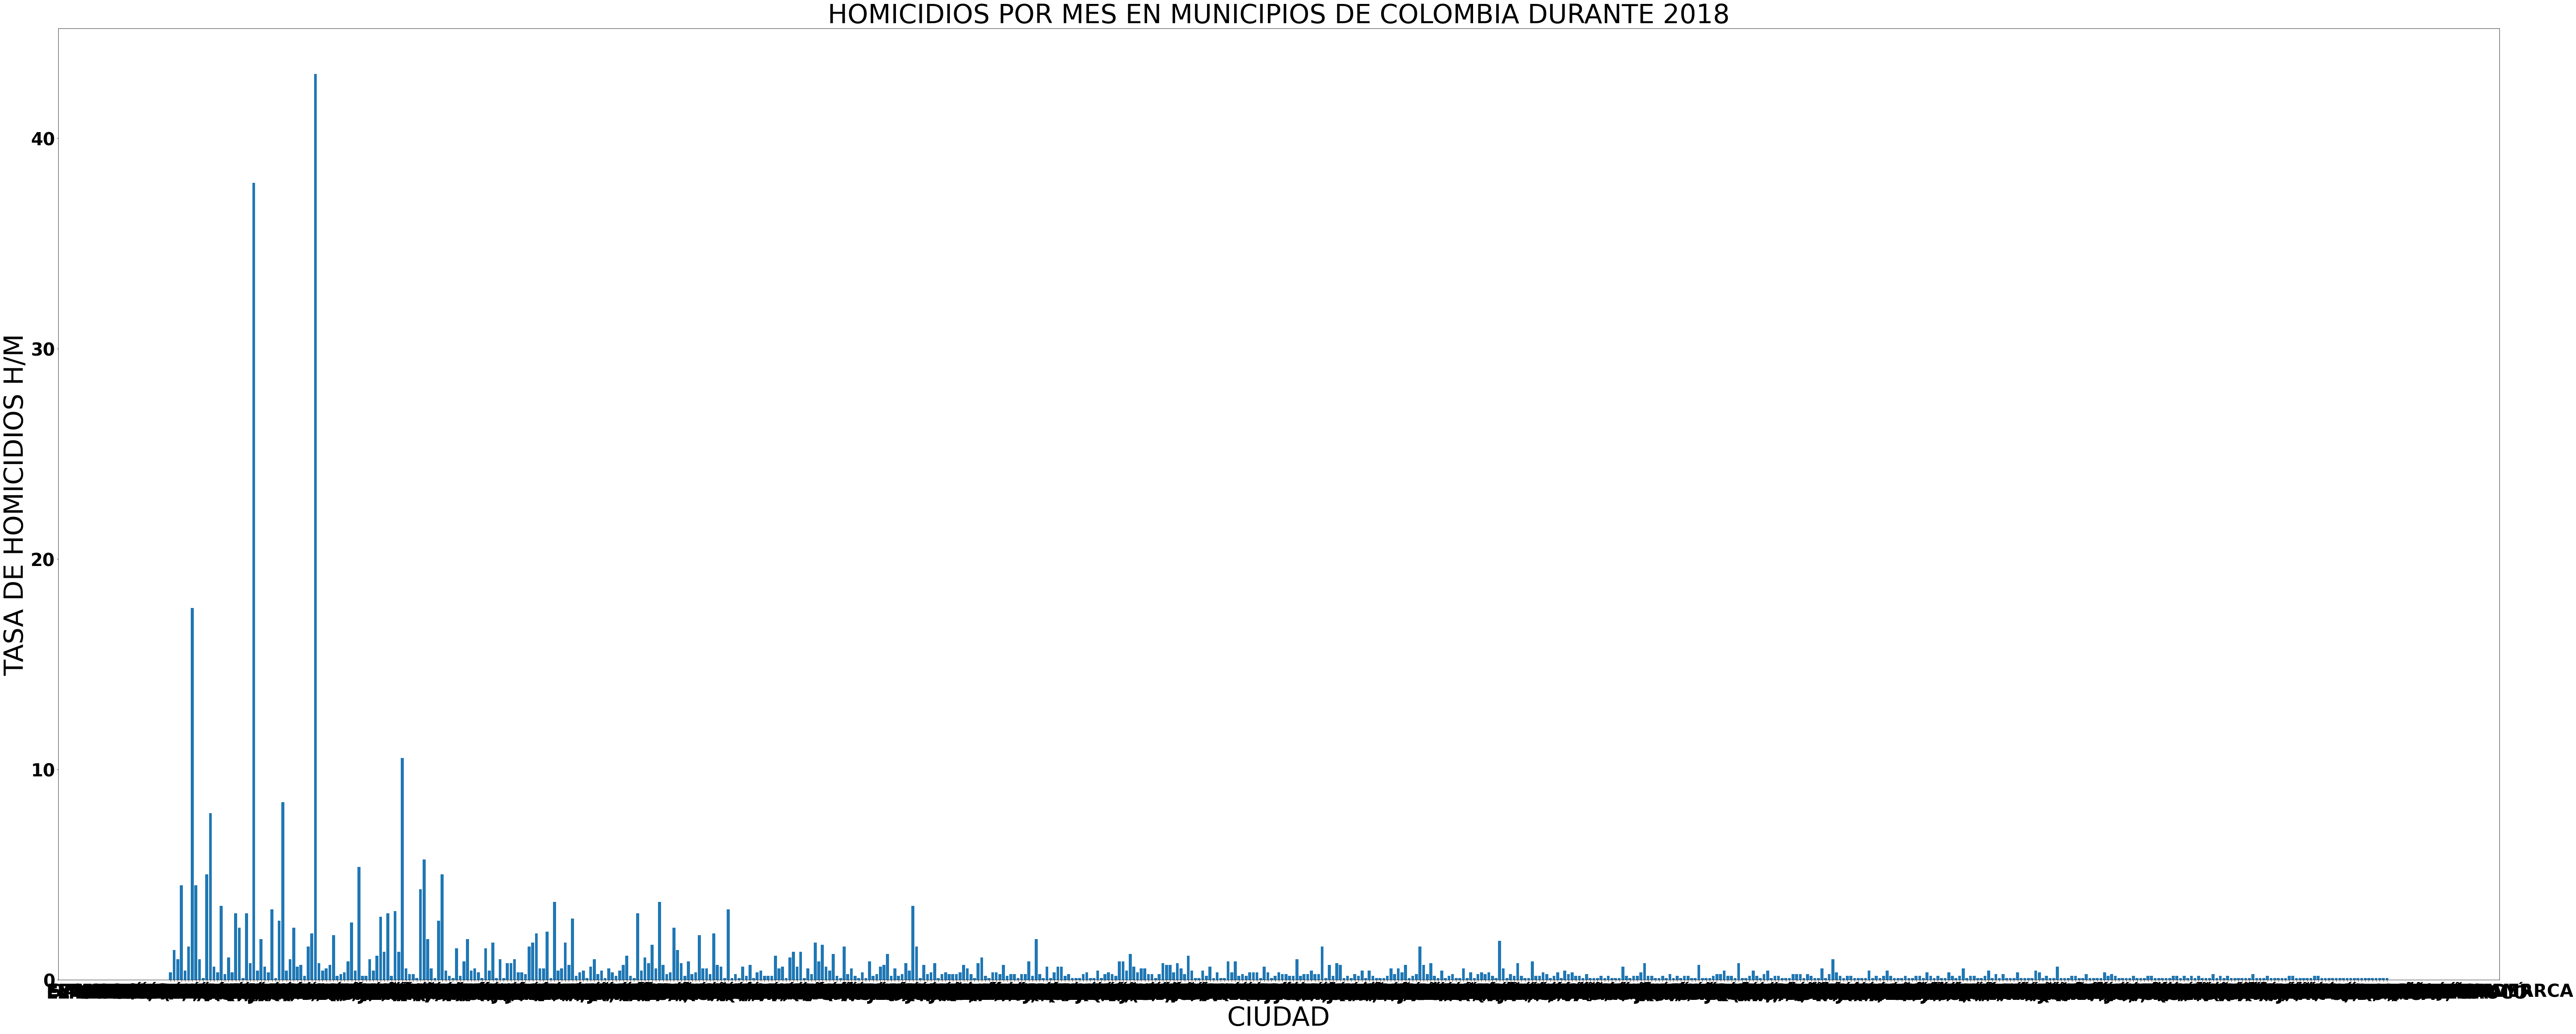

In [97]:
plt.bar(Historial_por_ciudad.keys(), Historial_por_ciudad.values()) #se crea la primera gráfica para mostrar el historial de los datos
plt.xlabel("CIUDAD", **axis_font)
plt.ylabel("TASA DE HOMICIDIOS H/M", **axis_font)
plt.title("HOMICIDIOS POR MES EN MUNICIPIOS DE COLOMBIA DURANTE 2018", **axis_font)
plt.show() #se muestra la gráfica

Dada la cantidad de municipios que se presentan en la base de datos, unas graficas como las mostradas anteriormente, aunque permiten determinar los municipios con más homicidios (Bogotá, Cali, Medellín), determinar el comportamiento de los homicidios o Hacerse una idea de la concentración de estos, no permiten analizar correctamente los valores de cada ciudad, y menos, responder a la pregunta inicial. Por lo que se deben eliminar varios municipios antes de realizar las gráficas. Como punto inicial se quiere que los municipios que entren en la gráfica tengan más de 5 veces la media de homicidios en colombia durante el año 2018 (dato adquirido a partir del método de prueba/error), por lo que a continuación se construye un código que permita hacer esto.  

In [12]:
MEDIA_HOMICIDIOS = np.sum(list(Historial_por_ciudad.values()))/len(list(Historial_por_ciudad.keys())) #se calcula la media en la tasa de homicidios
print(MEDIA_HOMICIDIOS)

0.7130221876908337


In [13]:
HOMICIDIOS_NOTABLES = {} #diccionario para almacenar las ciudades con niveles más altos de homicidios y la cantidad de estos
for j,k in Historial_por_ciudad.items(): #j = clave, k = valor 
  if k > MEDIA_HOMICIDIOS*5: #si se supera 5 vece la media de homicidios
    HOMICIDIOS_NOTABLES[j] = k #se almacena la ciudad y sus valores

In [14]:
HOMICIDIOS_NOTABLES

{'BARRANQUILLA (CT), ATLÁNTICO': 10.54481546572932,
 'BOGOTÁ D.C. (CT), CUNDINAMARCA': 37.87346221441109,
 'CALI (CT), VALLE': 43.05799648506133,
 'CARTAGENA (CT), BOLÍVAR': 7.908611599296995,
 'CAUCASIA, ANTIOQUIA': 4.481546572934972,
 'CÚCUTA (CT), NORTE DE SANTANDER': 5.711775043936724,
 'MEDELLÍN (CT), ANTIOQUIA': 17.6625659050966,
 'PALMIRA, VALLE': 5.008787346221437,
 'QUIBDÓ (CT), CHOCÓ': 3.6906854130052733,
 'SAN ANDRES DE TUMACO, NARIÑO': 8.43585237258346,
 'SOACHA, CUNDINAMARCA': 5.3602811950790805,
 'SOLEDAD, ATLÁNTICO': 5.008787346221437,
 'TARAZÁ, ANTIOQUIA': 3.6906854130052733,
 'TURBO, ANTIOQUIA': 4.481546572934972,
 'VILLAVICENCIO (CT), META': 4.3057996485061505}

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


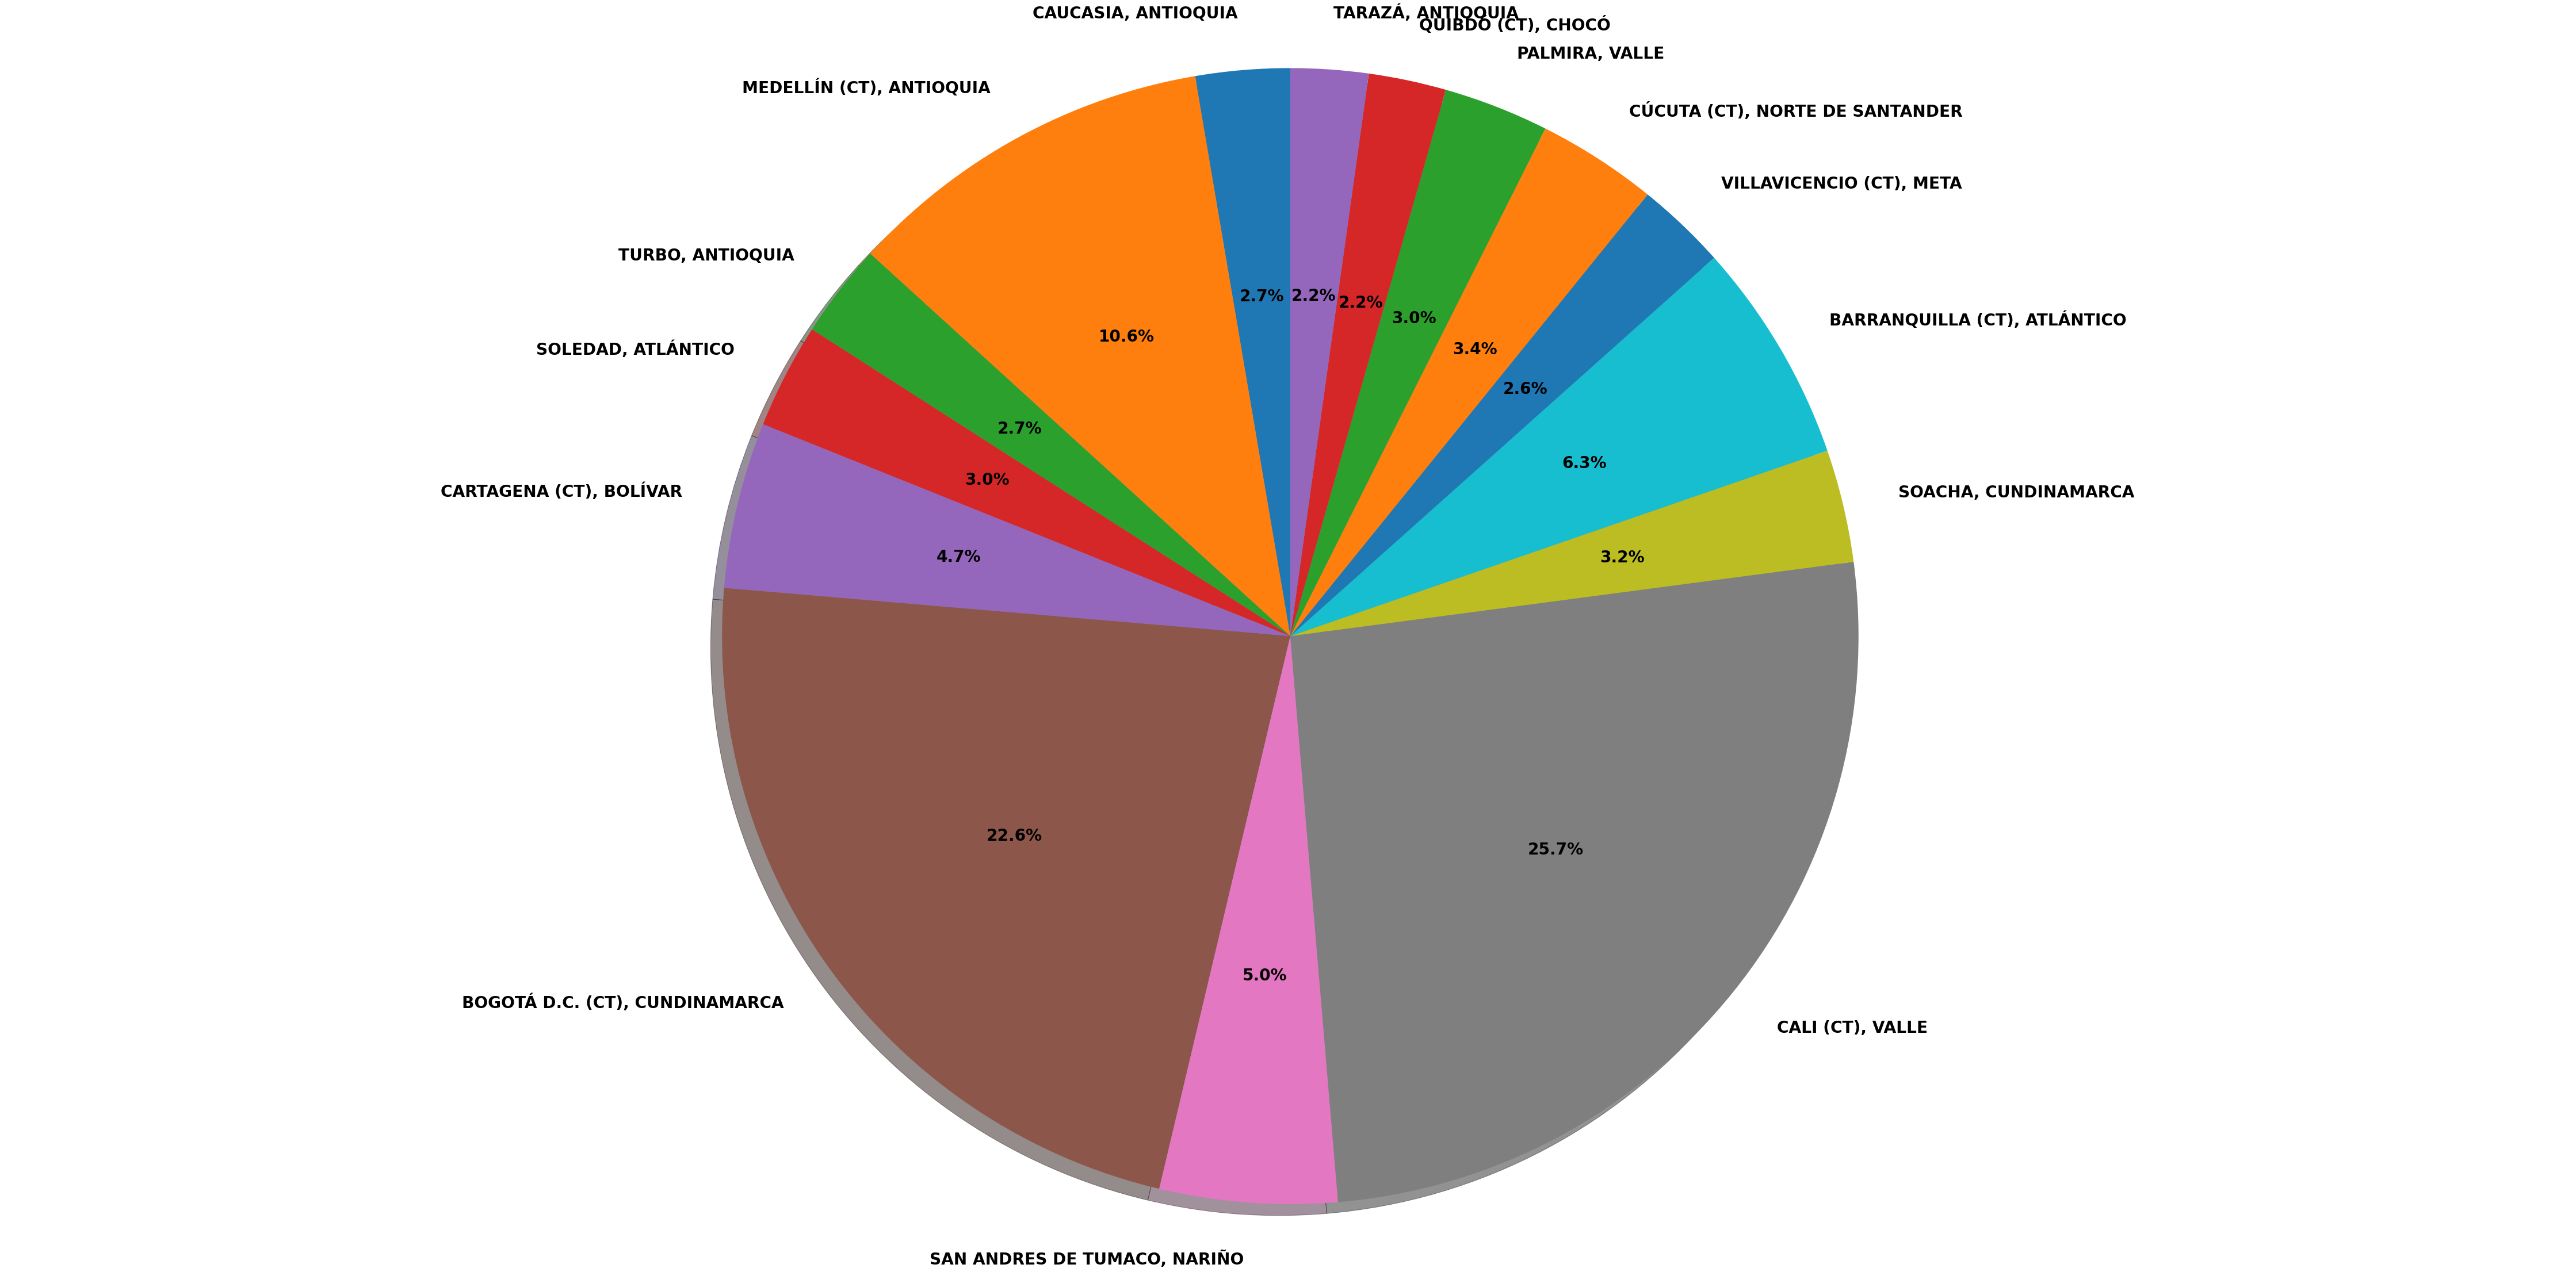

In [15]:
labels = HOMICIDIOS_NOTABLES.keys() #los labels para una gráfica circular son las claves del diccionario.
sizes = HOMICIDIOS_NOTABLES.values() #el tamaño son la cantidad de homicidios en cada ciudad
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)
#se muestra la gráfica 
fig1, ax1 = plt.subplots() 
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Para hacer los datos más legibles es conveniente usar siglas para cada una de las ciudades, para hacer estas siglas, se va a usar como convención, las 3 primeras letras de la ciudad.

In [16]:
ULTIMO_DICT = {} #diccionario para almacenar las siglas
for j,k in HOMICIDIOS_NOTABLES.items():
  ULTIMO_DICT[j[0:3]]=k #se almacenan solo las 3 primeras letras de la ciudad, en vez de todo el nombre

ULTIMO_DICT

{'BAR': 10.54481546572932,
 'BOG': 37.87346221441109,
 'CAL': 43.05799648506133,
 'CAR': 7.908611599296995,
 'CAU': 4.481546572934972,
 'CÚC': 5.711775043936724,
 'MED': 17.6625659050966,
 'PAL': 5.008787346221437,
 'QUI': 3.6906854130052733,
 'SAN': 8.43585237258346,
 'SOA': 5.3602811950790805,
 'SOL': 5.008787346221437,
 'TAR': 3.6906854130052733,
 'TUR': 4.481546572934972,
 'VIL': 4.3057996485061505}

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


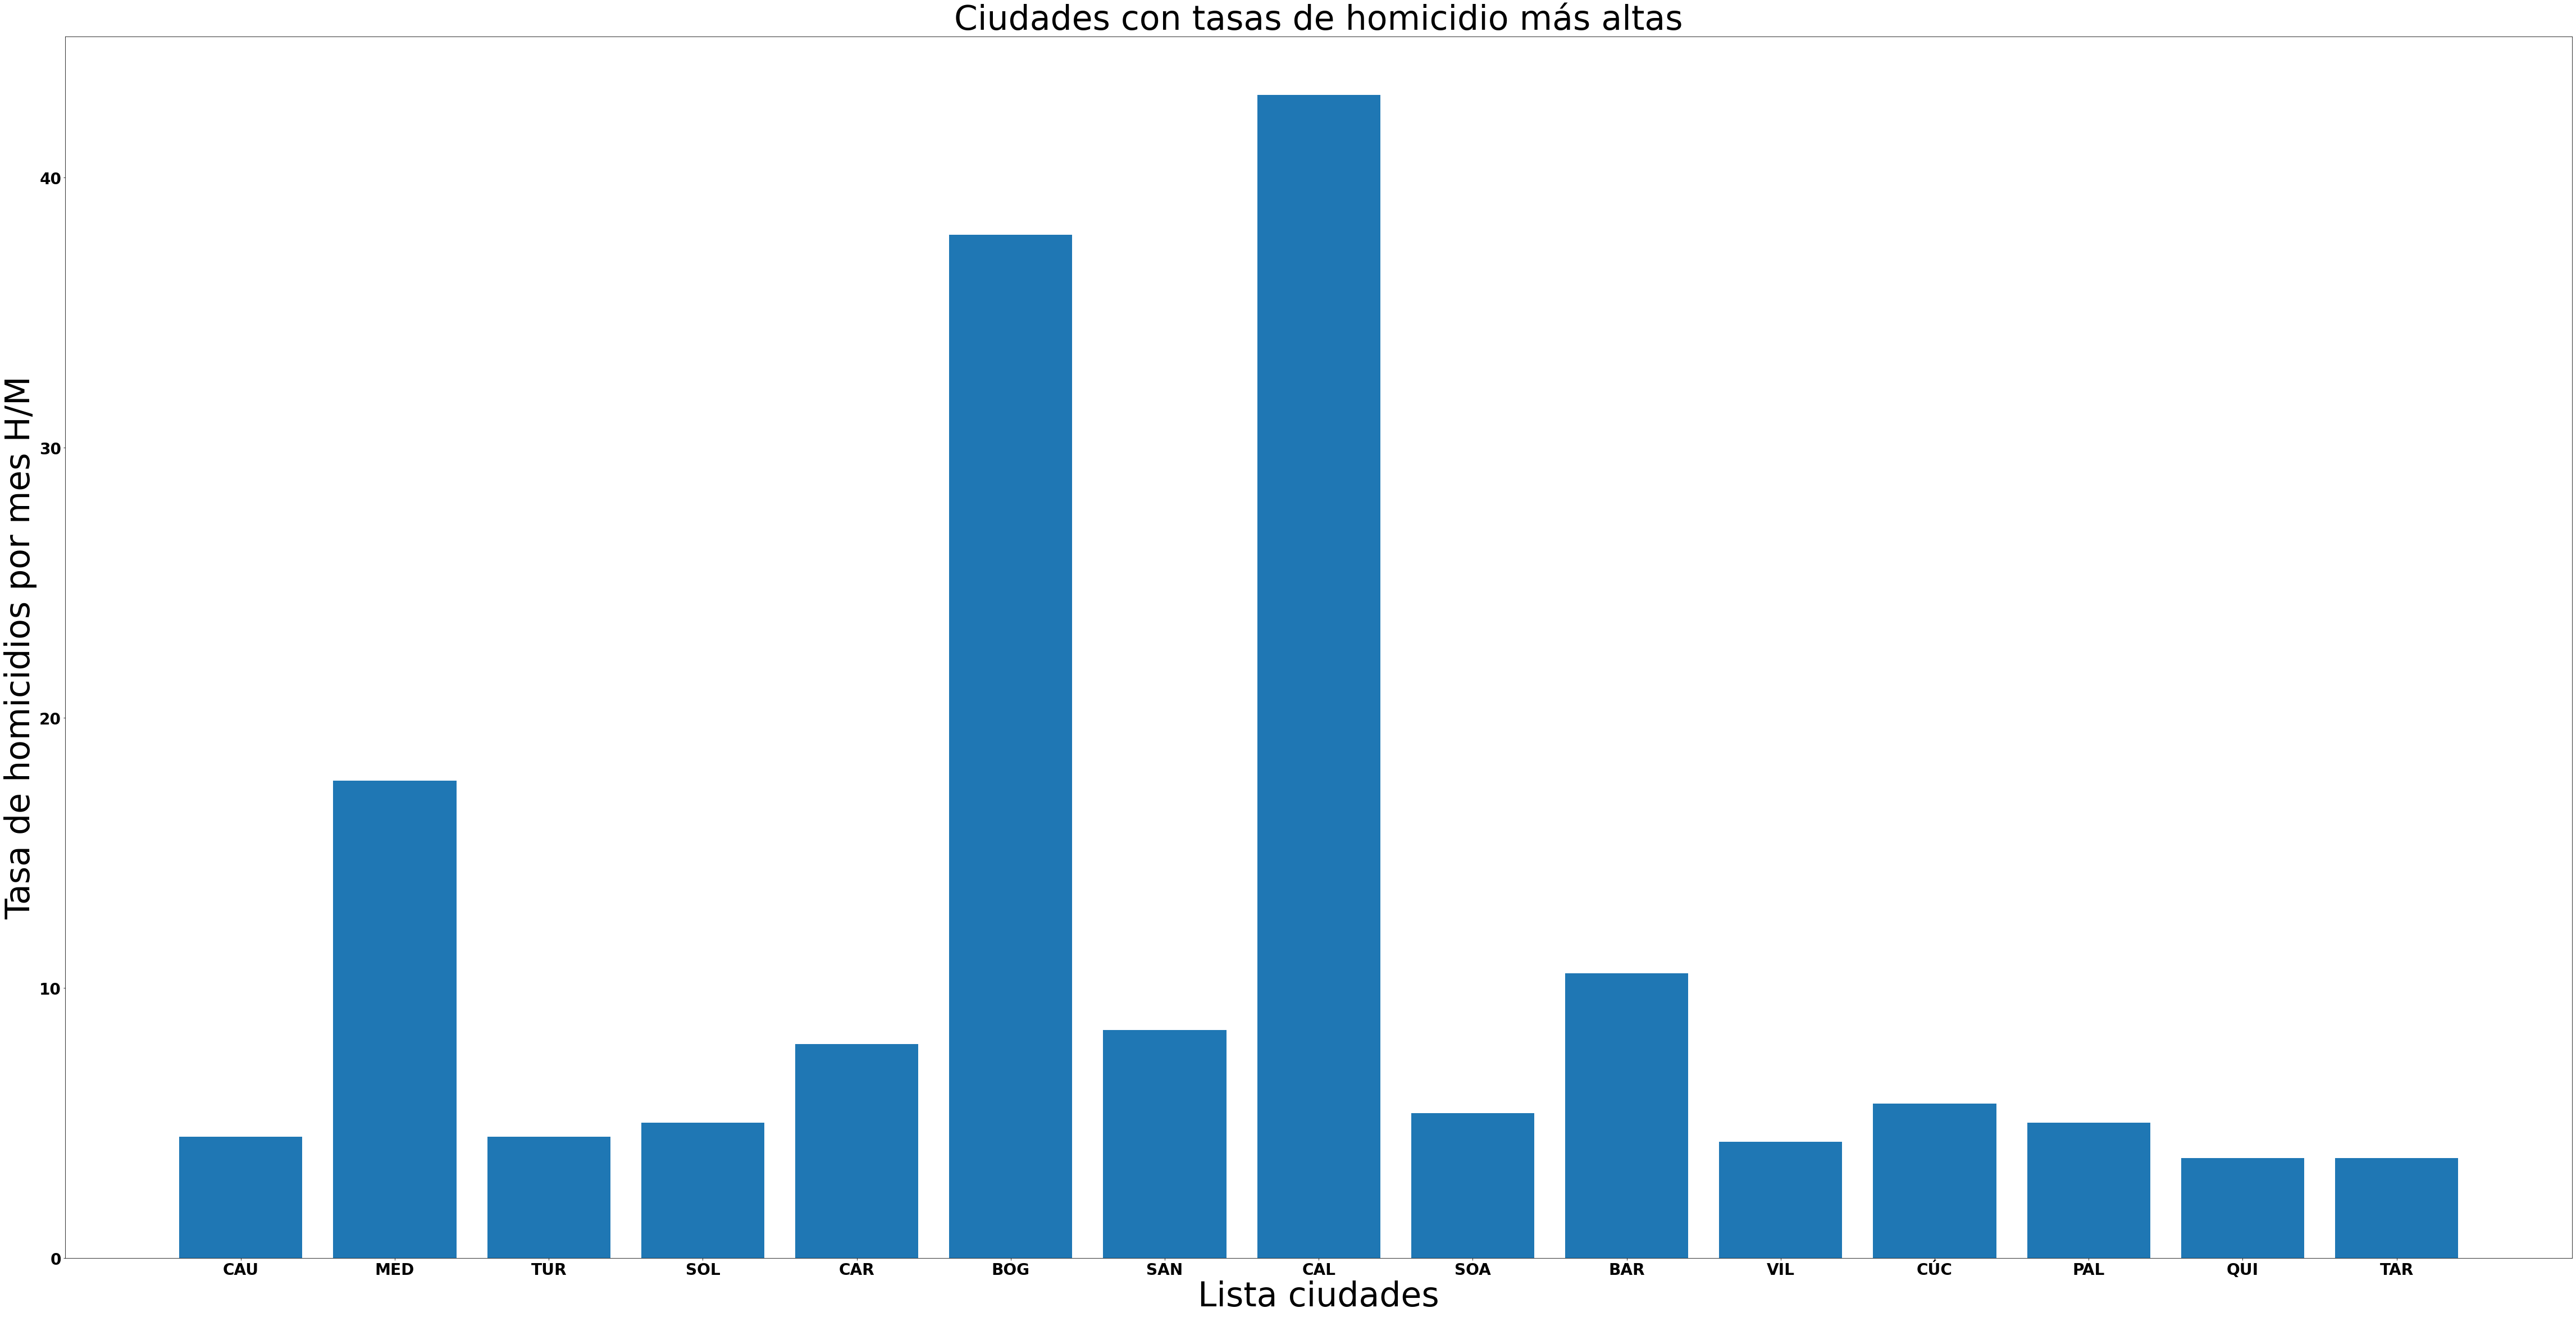

In [17]:
#Se muestra la gráfica de barras
plt.bar(ULTIMO_DICT.keys(), ULTIMO_DICT.values())
plt.xlabel("Lista ciudades", **axis_font)
plt.ylabel("Tasa de homicidios por mes H/M", **axis_font) #H/M = homicidios/mes
plt.title("Ciudades con tasas de homicidio más altas", **axis_font)
plt.rc('xtick', labelsize=60)    # fontsize of the tick labels
plt.rc('ytick', labelsize=60)    # fontsize of the tick labels
plt.show()

Con esto se concluye que las ciudades con tasas de Homicidio más grandes son Cali con una tasa de 43.05 H/M, Bogotá con 37.87 H/M y medellín con 17.66 H/M 

##¿Qué barrio en Bogotá presentan mayor número de muertos entre las 6 pm y 12 am?

Para solucionar la siguiente pregunta se debe repetir el proceso 
anterior, pero esta vez solo contando los Homicidios entre las 18:00 y las 23:59. Además, este proceso puede ser repetido para cualquier ciudad de Colombia, por lo que se creó una función que permitiera ingresar como parametros, el nombre del municipio, el departamento y el rango horario y retorne una lista con los homicidios en el municipio.  

In [18]:
#se recibe como parámetro el municipio y departamento que se quiere consultar como strings, la Hora de inicio del rango Hora_inicio
#y la hora final de este Hora_fin como strings de la forma "HH:MM:SS"
def Homicidios_municipio_horas(municipio, departamento, Hora_inicio, Hora_fin): 
  Historial_por_hora = {} #diccionario donde se van a almacenar los valores de barrio y número de Homicidios
  Datos_bogota = datos.loc[datos.loc[:, 'Municipio'] == municipio] #Se filtran los datos primero por el nombre de la ciudad
  Datos_bogota = Datos_bogota.loc[datos.loc[:, 'Departamento'] == departamento] #con el fin de evitar confuciones se filtran también por depto
  hora_inicio = dt.time(*map(int, Hora_inicio.split(':'))) #se transforma el string de inicio a datetime para analizarlo facilmente 
  hora_fin = dt.time(*map(int, Hora_fin.split(':'))) #se transforma el string de inicio a datetime para analizarlo facilmente
  a,b = Datos_bogota.shape #Forma de los datos, a = filas del dataframe, b = columnas del dataframe
  for i in range(a): 
    hora = dt.time(*map(int, Datos_bogota.iloc[i,0][11:].split(':'))) #se obtiene la hora del registro actual
    if  hora_inicio > hora_fin: #con el fin de validar cualquier rango de horas ingresado, se añade un condicional para cuando el rango ingresado tenga un cambio de dia
      
      if (hora >= hora_inicio and hora <= dt.time(23,59)) or (hora>= dt.time(00,00) and hora <= hora_fin): #si la hora está en el rango que pasa por media noche, se añade
        Historial_por_hora[Datos_bogota.iloc[i,4]]=Historial_por_hora.get(Datos_bogota.iloc[i,4],0)+Datos_bogota.iloc[i,17]

    elif hora >= dt.time(*map(int, Hora_inicio.split(':'))) and hora <= dt.time(*map(int, Hora_fin.split(':'))): #si el rango no pasa por media noche y la hora se encuentra en el rango
      Historial_por_hora[Datos_bogota.iloc[i,4]]=Historial_por_hora.get(Datos_bogota.iloc[i,4],0)+Datos_bogota.iloc[i,17] #se añade al diccionario
  return Historial_por_hora #se retorna la lista de homicidios, clasificados por barrio en el municipio y rango horario indicado

Se aplica el método anterior al caso puntual de Bogotá 

In [19]:
#Se quiere saber los barrios de bogotá con más homicidios entre las 18:00 y las 24
Historial_barrios_bogota = Homicidios_municipio_horas('BOGOTÁ D.C. (CT)','CUNDINAMARCA','18:00','23:59')

Como se hizo anteriormente, se seguirá el mismo proceso de antes para eliminar los barrios con bajas tasas de homicidios que no aporten a la solución.  

In [20]:
MEDIA_HOMICIDIOS2 = np.sum(list(Historial_barrios_bogota.values()))/len(list(Historial_barrios_bogota.keys())) #mmedia de los datos
print(MEDIA_HOMICIDIOS2)

1.1891891891891893


In [21]:
HOMICIDIOS_NOTABLES_HORA = {} #se almacenan solo los datos con más de 2 medias estandar

for j,k in Historial_barrios_bogota.items():
  if k >= MEDIA_HOMICIDIOS2*2:
    HOMICIDIOS_NOTABLES_HORA[j] = k

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


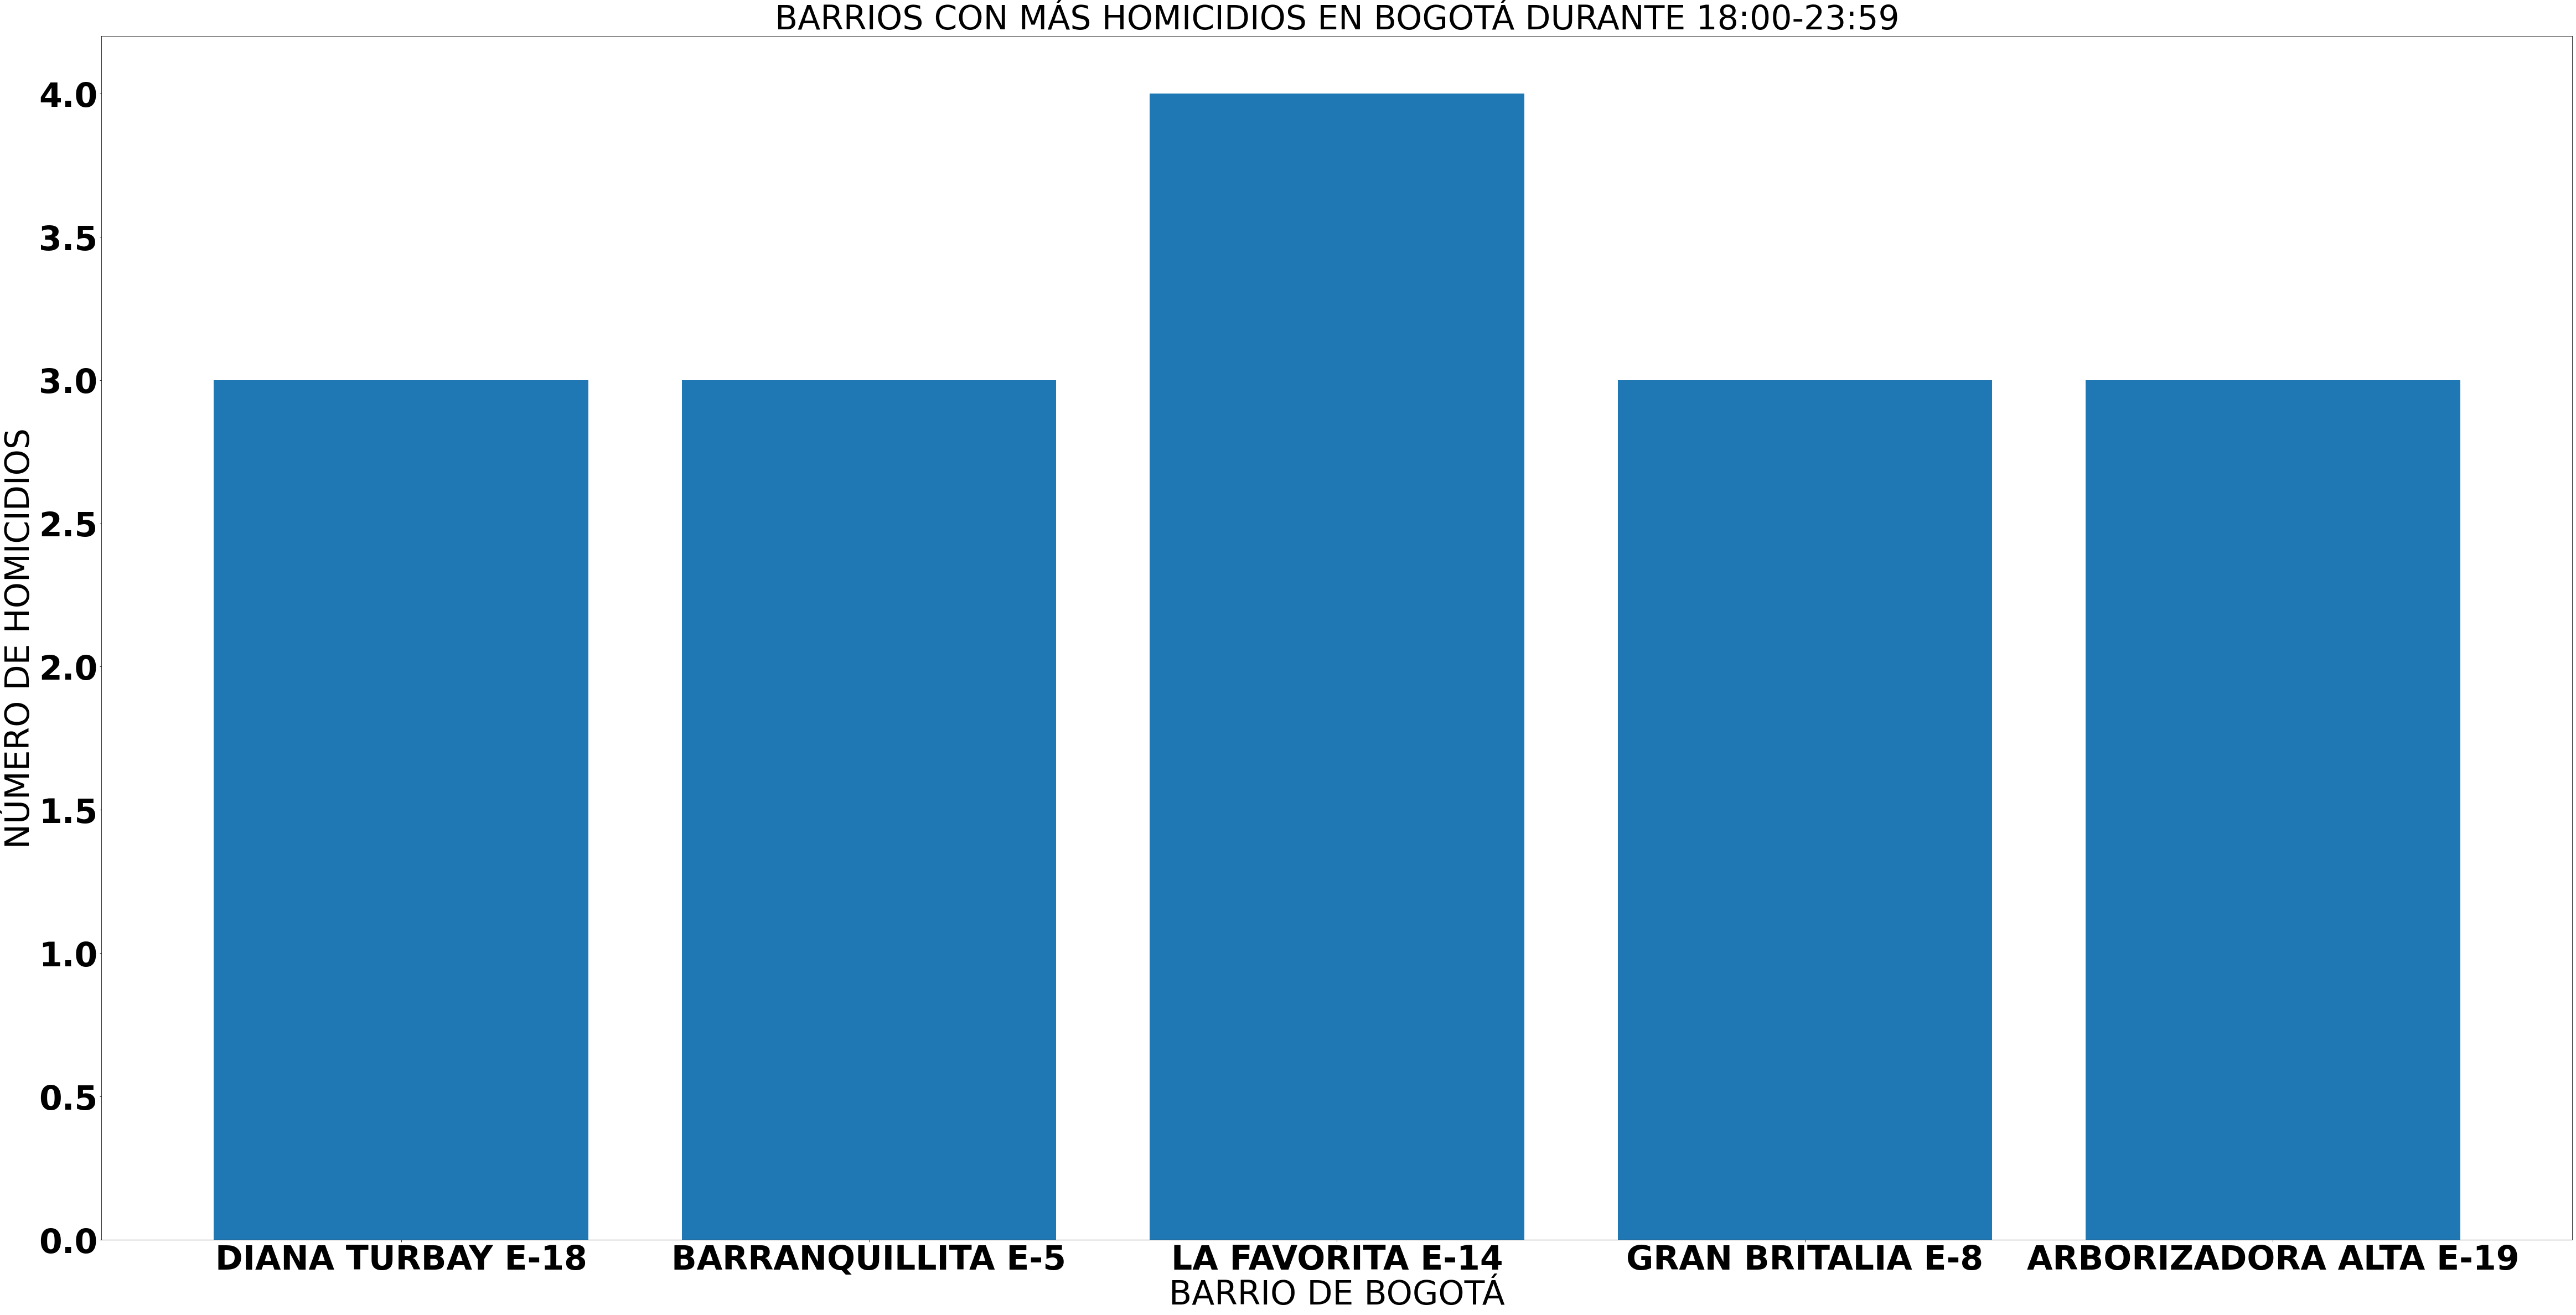

In [22]:
plt.bar(HOMICIDIOS_NOTABLES_HORA.keys(), HOMICIDIOS_NOTABLES_HORA.values()) #Gráfica de Barras con los 5 Barrios con más asesinatos en 2018
plt.xlabel("BARRIO DE BOGOTÁ", **axis_font)
plt.ylabel("NÚMERO DE HOMICIDIOS", **axis_font)
plt.title("BARRIOS CON MÁS HOMICIDIOS EN BOGOTÁ DURANTE 18:00-23:59", **axis_font)
plt.show()

Se crea una gráfica de pastel netamente informativa, con el fin de dar una idea de como se reparten los homicidios los 5 barrios que presentan más casos.

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


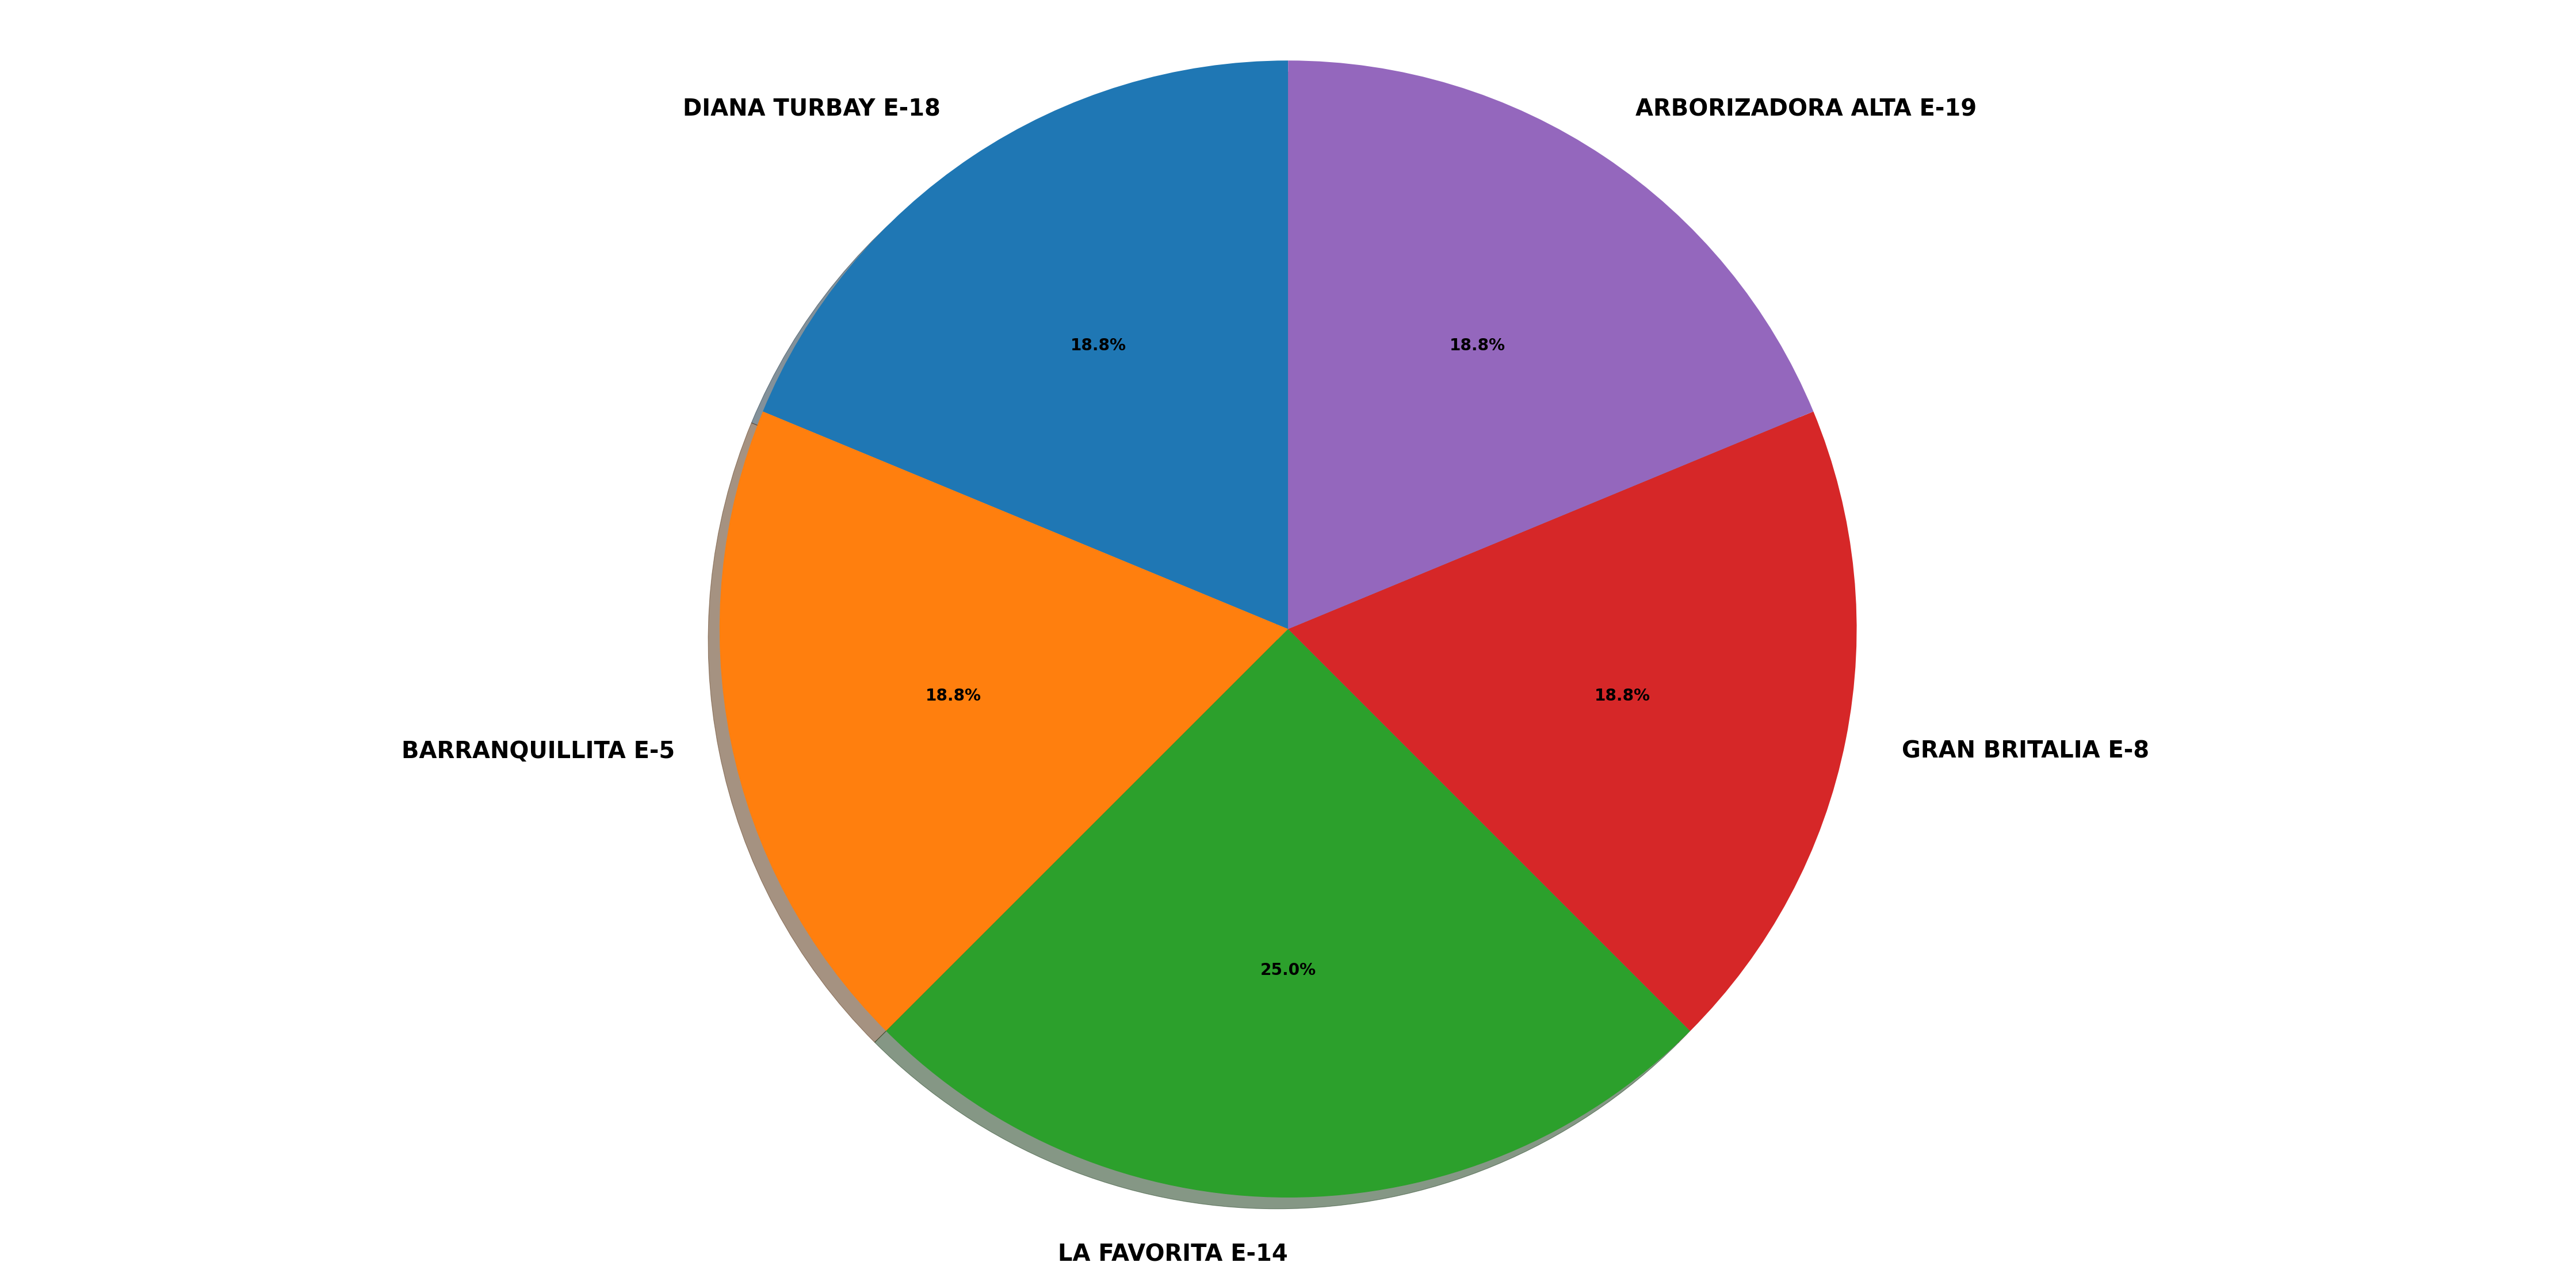

In [23]:
labels = HOMICIDIOS_NOTABLES_HORA.keys()
sizes = HOMICIDIOS_NOTABLES_HORA.values()
plt.rc('xtick', labelsize=40) 
plt.rc('ytick', labelsize=40) 
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

**Con lo que se concluye que los Barrios con más homicidios entre las 18:00 y las 23:59 en Bogotá en el año 2018 fueron, La favorita, Barranquillita, Gran Britalia, Diana Turbay y Arborizadora, con 4,3,3,3 Homicidios respectivamente.**

## ¿Qué otras conclusiones puedes encontrar?

Para la pregunta final, aunque ya es posible calcular los barrios con mayores homicidios en cualquier franja horaria y se conoce los municipios con mayores tasas de homocidio, quedan por responder varias preguntas respondibles con este dataset, como:

- ¿Que barrio de cualquier municipio de colombia tiene la mayor tasa de homicidios?

- ¿cual es el departamento con mayor número de homicidios?

- ¿Qué día se presentan la mayor cantidad de muertes?

- ¿cómo se comparan las "clases de sitio" en cantidad de asesinatos?

- ¿Cómo se comportan las muertes en un rango de edad definido y un municipio definido?

- ¿Qué sexo predomina entre los muertos?

- ¿Qué estado civil predomina en las muertes?

Así que en las siguientes celdas se irá respondiendo cada una de estas:

In [24]:
#El método recibe como parámetros la etiqueta de la base de datos "aspecto" y el factor de multiplicación de la media con el que se desea
#filtrar los datos y retorna una lista con las clases con valores más elevdos segun el criterio.  
def calcular_insights(aspecto, factor):
  a,b = datos.shape # a = filas, b = columnas 
  Historial_por_aspecto = {} #diccionario donde se almacenarán los valores 
  for i in range(a):
    #En la clave del diccionario definida para ese aspecto, se suma la cantidad de homicidios para esa fila de la tabla 
    Historial_por_aspecto[datos.loc[i,aspecto]]=Historial_por_aspecto.get(datos.loc[i,aspecto],0)+datos.loc[i,'Cantidad']
  MEDIA_HOMICIDIOS_A = np.sum(list(Historial_por_aspecto.values()))/len(list(Historial_por_aspecto.keys())) #se calcula la media para filtrar los resultados

  HOMICIDIOS_NOTABLES_ASPECTO = {}

  for j,k in Historial_por_aspecto.items(): #j = claves del diccionario, k= valores del diccionario
    if k >= MEDIA_HOMICIDIOS_A*factor: #si el valor actual supera la razón factor*media
      HOMICIDIOS_NOTABLES_ASPECTO[j] = k #se almacena en el diccionario final
  return HOMICIDIOS_NOTABLES_ASPECTO #se retorna el diccionario filtrado

El método anterior puede responder la mayoria de las preguntas propuestas anteriormente, siempre y cuando se suministre a este una columna correctamente nombrada del dataset

###¿cual es el departamento con mayor número de homicidios?

A continuación se van a encontrar los departamentos con mayor número de homicidios en el año 2018 usando la función "calcular_insights"

In [25]:
Historial_por_departamento=calcular_insights('Departamento', 1.5) #se calcula la lista de homicidios por departamento y se muestran los 
#departamentos con más de 1.5 medias

In [26]:
Historial_por_departamento

{'ANTIOQUIA': 927,
 'CAUCA': 284,
 'CUNDINAMARCA': 581,
 'NARIÑO': 264,
 'VALLE': 890}

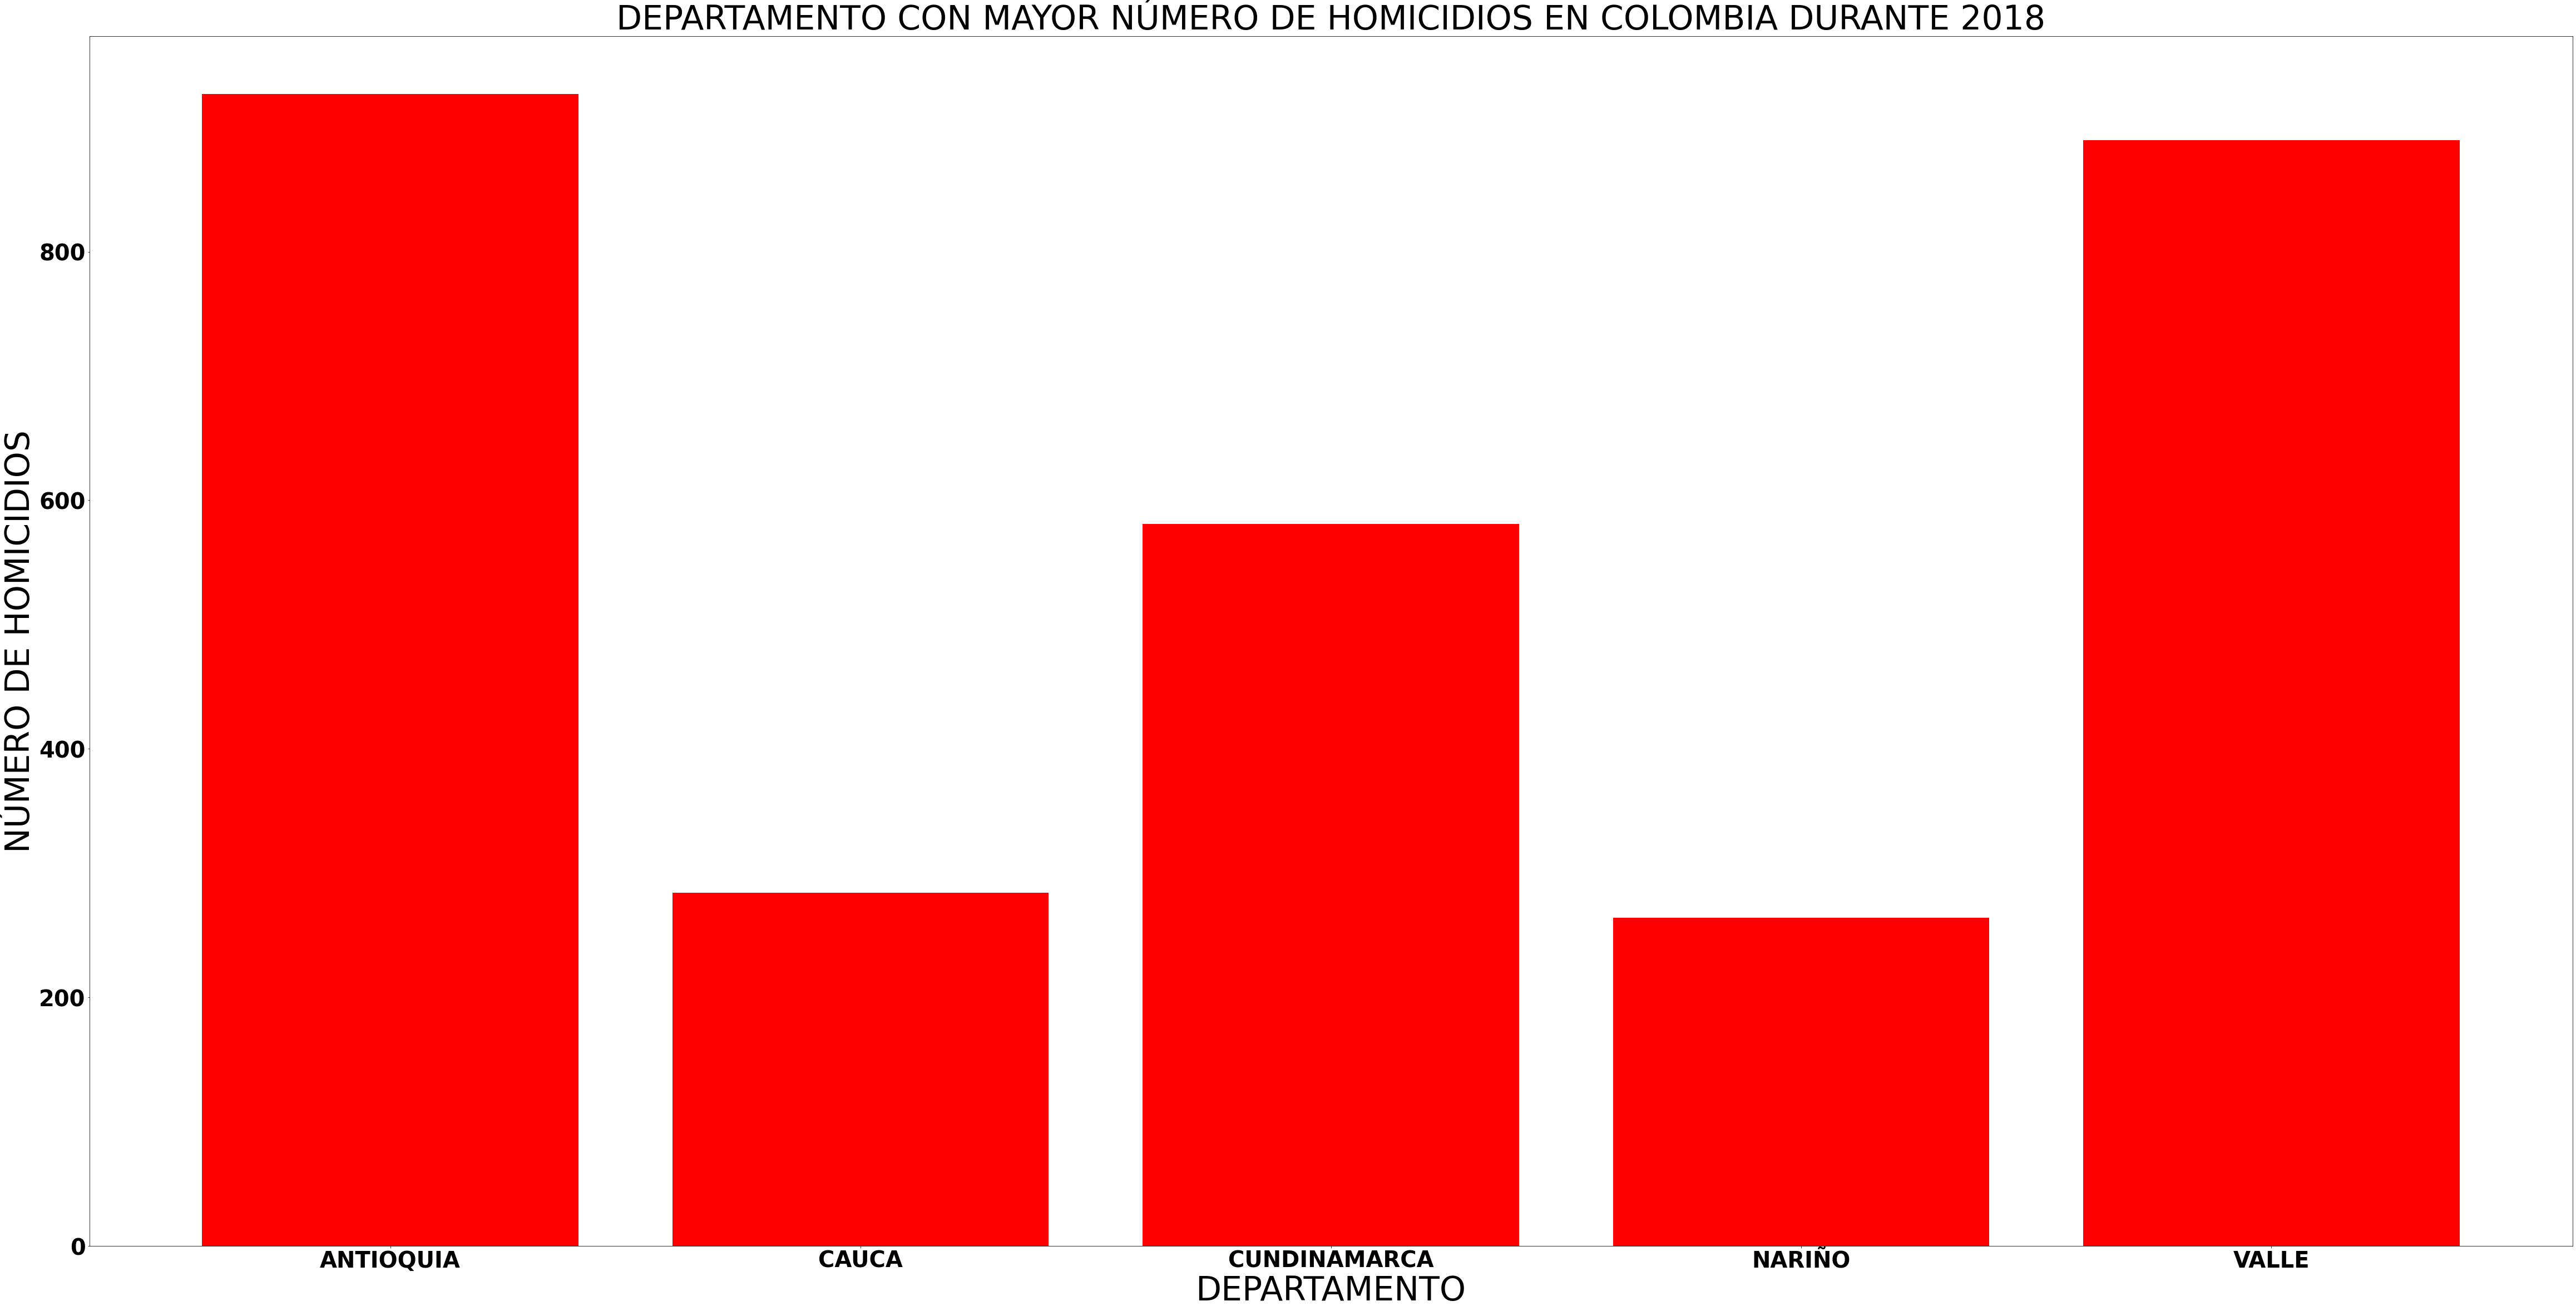

In [27]:
plt.bar(Historial_por_departamento.keys(), Historial_por_departamento.values(), color = 'r') #se grafican los valores en un gráfico de barras
plt.xlabel("DEPARTAMENTO", **axis_font)
plt.ylabel("NÚMERO DE HOMICIDIOS", **axis_font)
plt.title("DEPARTAMENTO CON MAYOR NÚMERO DE HOMICIDIOS EN COLOMBIA DURANTE 2018", **axis_font)
plt.show()

Con esto se puede concluir que los departamentos con más homicidios de colombia son: Valle con 890, Antioquia con 927, Cauca con 284, Cundinamarca con 581 y Nariño con 264.

###¿Qué día de la semana se presentan la mayor cantidad de muertes?

A continuación se van a encontrar los días de la semana con mayor número de homicidios en el año 2018 usando la función "calcular_insights"

In [28]:
Historial_por_dia=calcular_insights('Día', 0.1) #se calcula la lista de homicidios por día de la semana con un filtro de 1.5 medias para
#que se muestren todos los resultados

In [29]:
Historial_por_dia

{'Domingo': 1087,
 'Jueves': 614,
 'Lunes': 771,
 'Martes': 538,
 'Miércoles': 582,
 'Sábado': 813,
 'Viernes': 569}

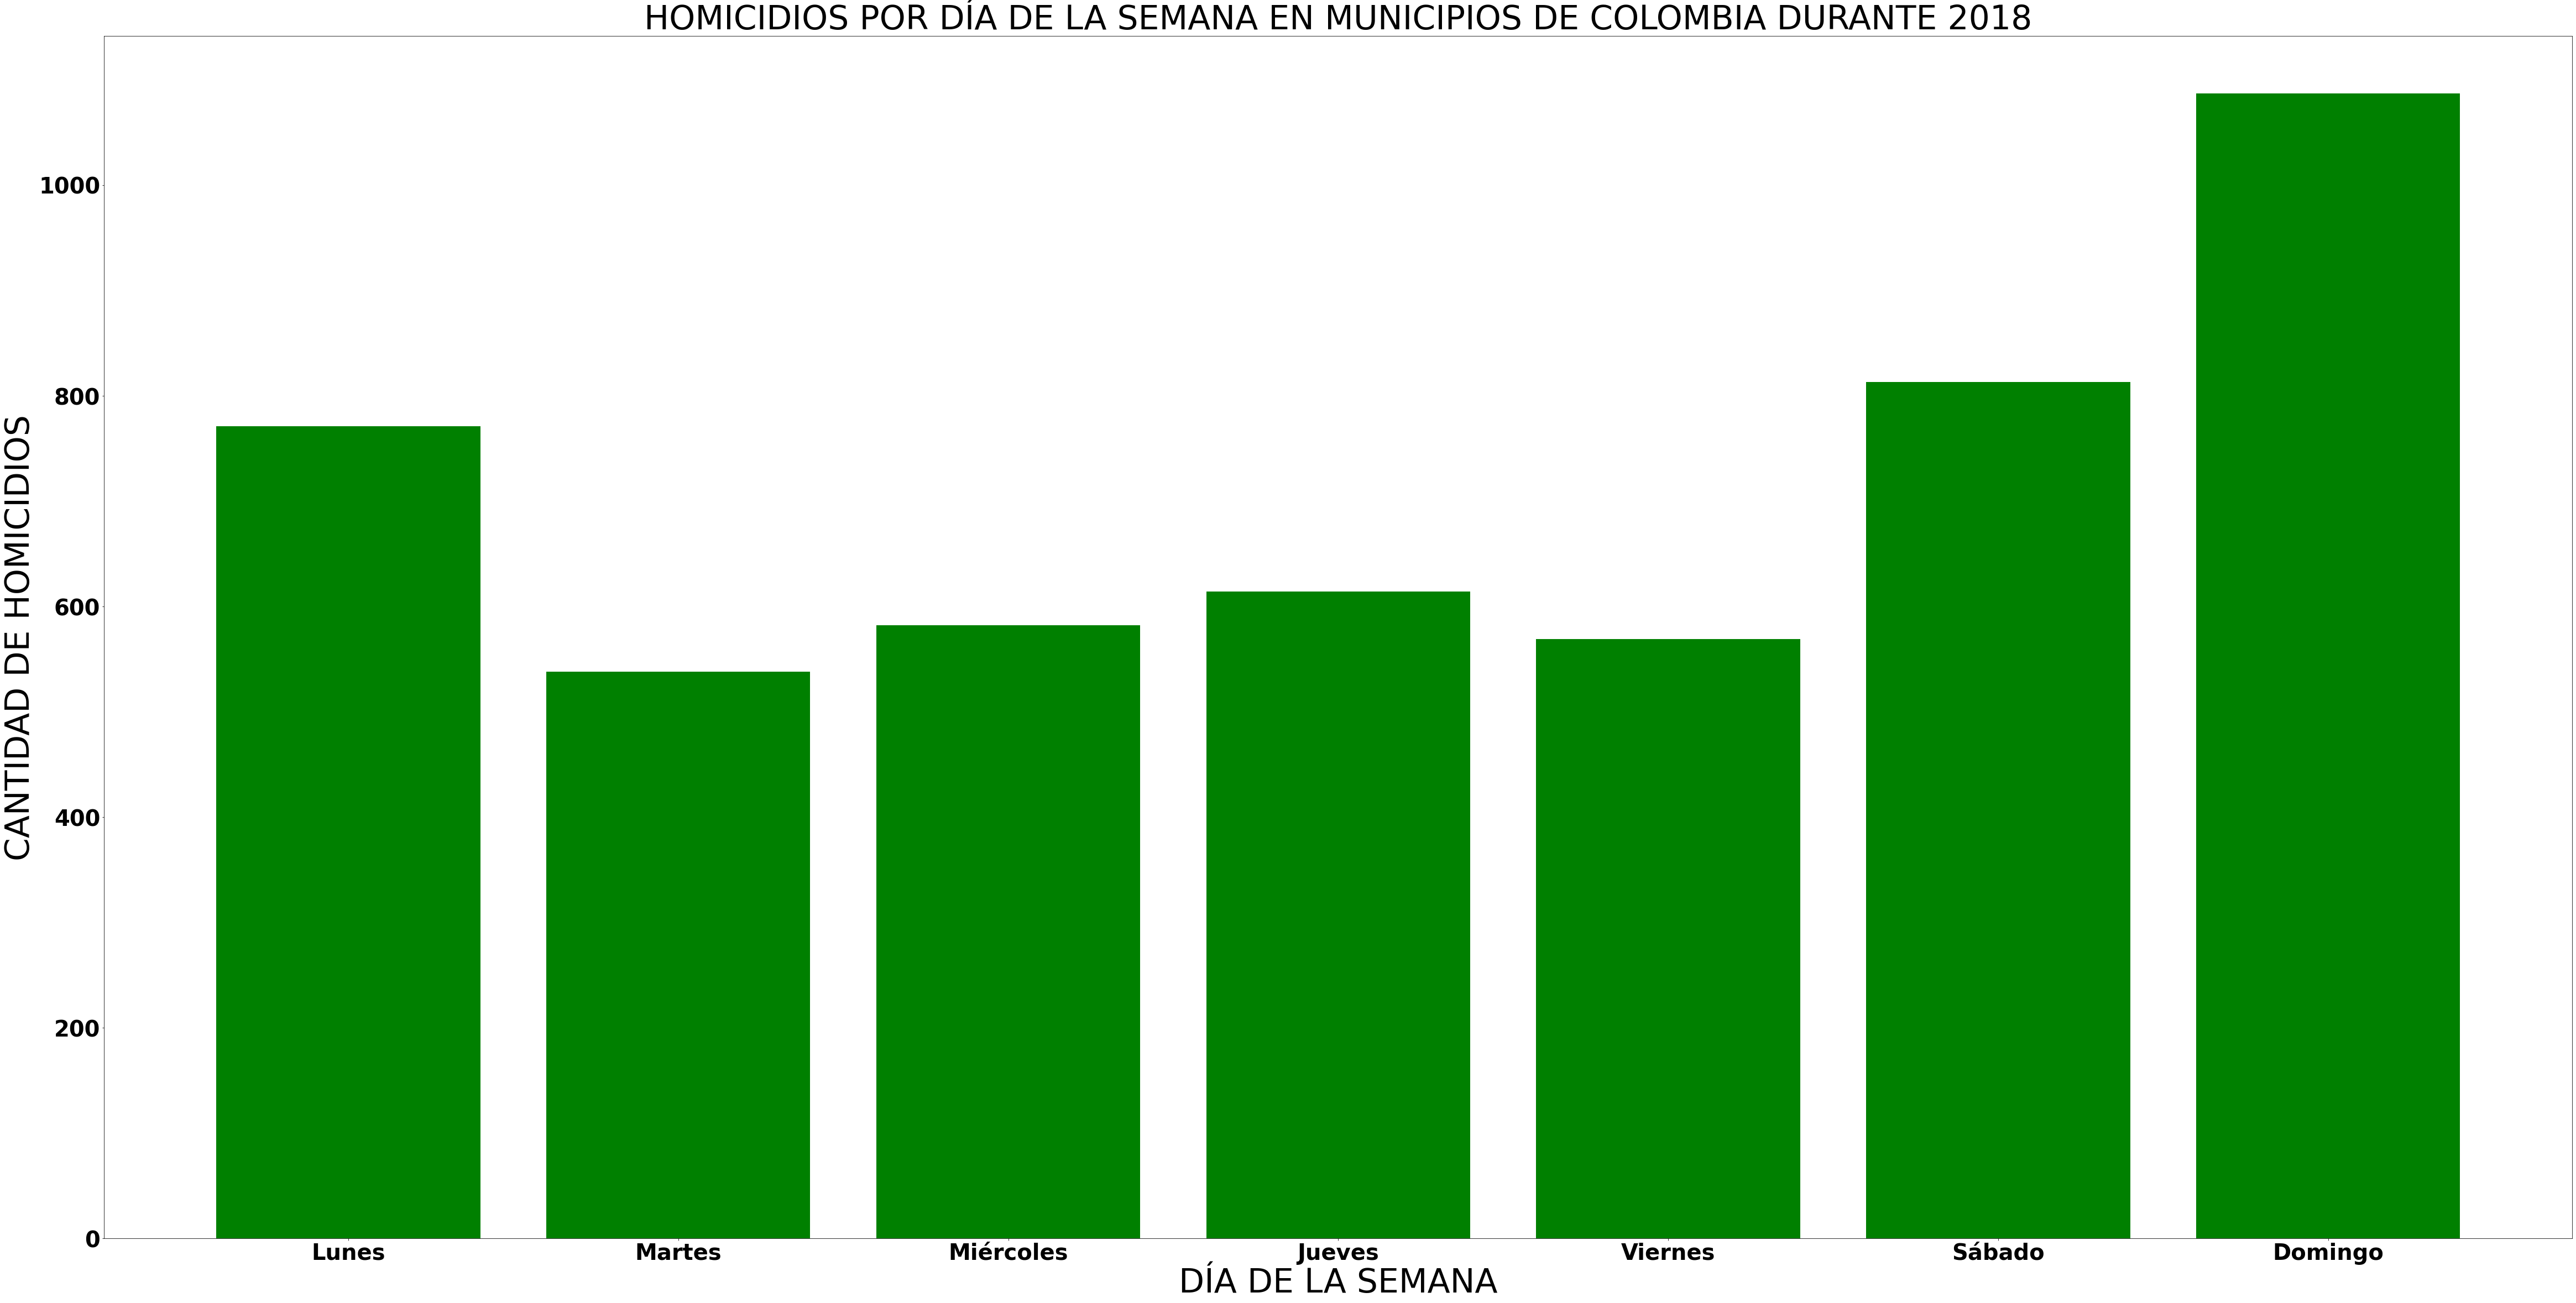

In [30]:
plt.bar(Historial_por_dia.keys(), Historial_por_dia.values(), color = 'g') #se grafican los homicidios en función de los días de la semana
plt.xlabel("DÍA DE LA SEMANA", **axis_font)
plt.ylabel("CANTIDAD DE HOMICIDIOS", **axis_font)
plt.title("HOMICIDIOS POR DÍA DE LA SEMANA EN MUNICIPIOS DE COLOMBIA DURANTE 2018", **axis_font)
plt.show()

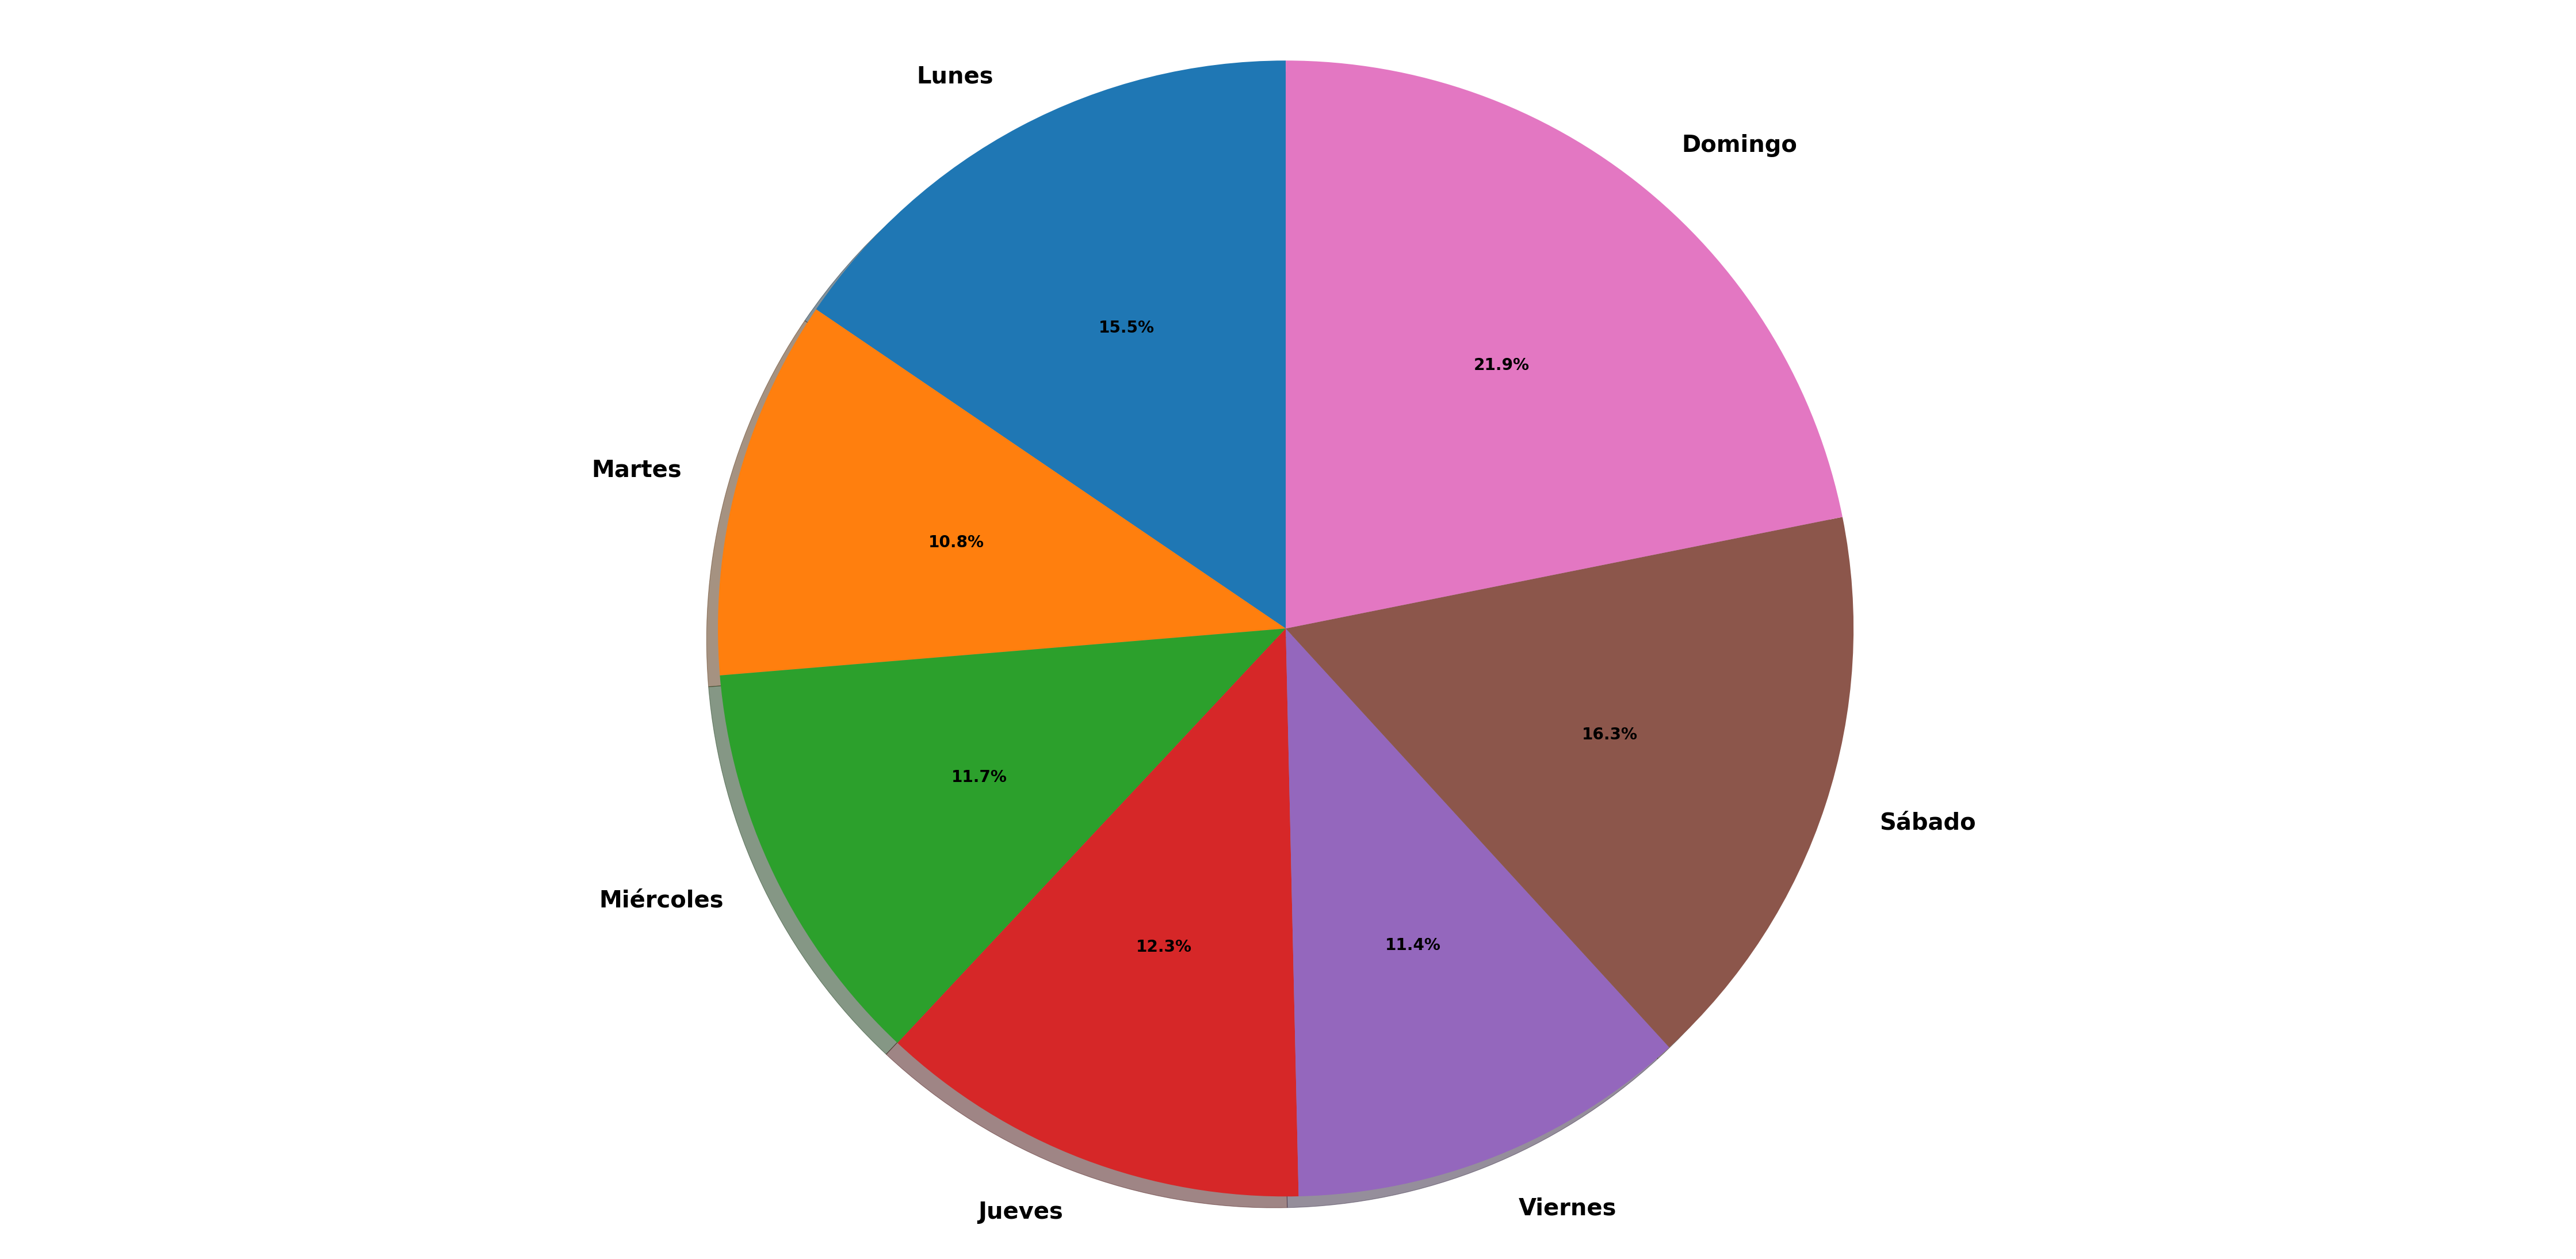

In [91]:
labels = Historial_por_dia.keys() #los labels para una gráfica circular son las claves del diccionario.
sizes = Historial_por_dia.values() #el tamaño son la cantidad de homicidios por genero
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)
#se muestra la gráfica 
fig1, ax1 = plt.subplots() 
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Con esto se puede concluir que los días con más Homocidios en el país son: Domingo con 1087 casos, Sabado con 813 y Lunes con 771. Del mismo modo, los días con menos Homicidios son Mártes y viernes con 538 y 569 casos respectivamente.

###¿cómo se comparan las "clases de sitio" en cantidad de asesinatos?

A continuación se van a encontrar las "clases de sitio" con mayor número de homicidios en el año 2018 usando la función "calcular_insights"

{'VIAS PUBLICAS': 2996, 'FINCAS Y SIMILARES': 561, 'CARRETERA': 144, 'CASAS DE HABITACION': 301}


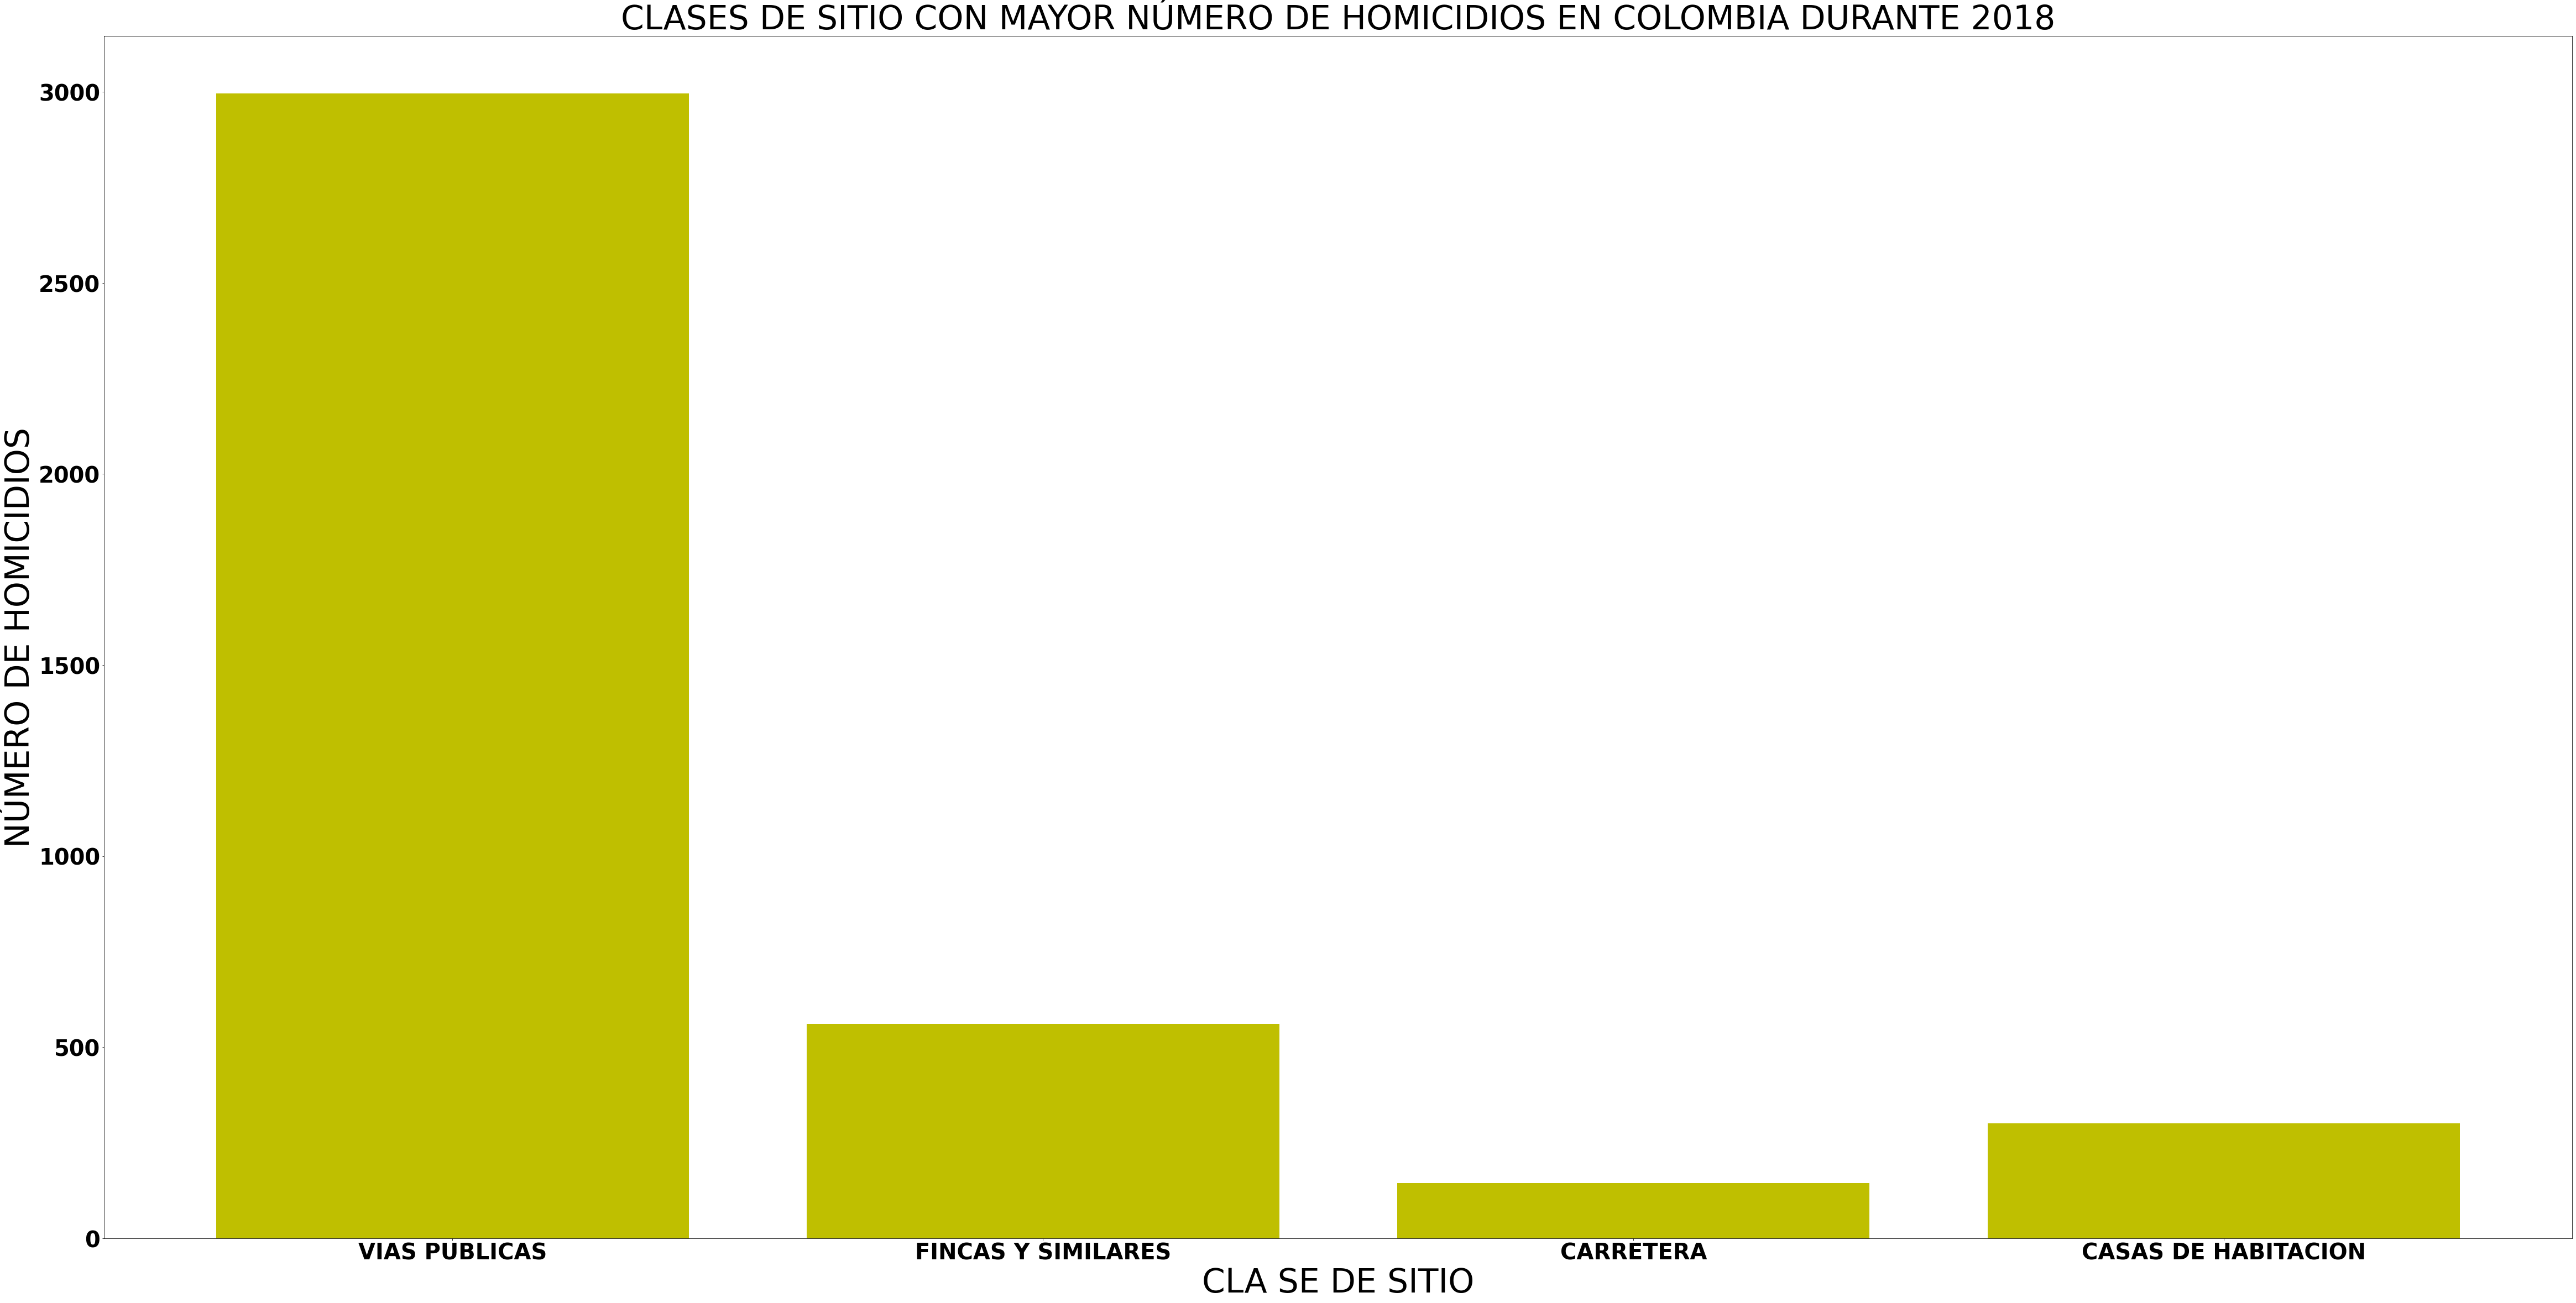

In [31]:
Historial_por_sitio=calcular_insights('Clase de sitio', 3) #se calcula la lista de homicidios por "clase de sitio" donde ocurrió el deseso
#con un filtro de 3 medias para mostrar solo los resultados más relevantes 
print(Historial_por_sitio) 
plt.bar(Historial_por_sitio.keys(), Historial_por_sitio.values(), color = 'y') #se grafican los resultados
plt.xlabel("CLA SE DE SITIO", **axis_font)
plt.ylabel("NÚMERO DE HOMICIDIOS", **axis_font)
plt.title("CLASES DE SITIO CON MAYOR NÚMERO DE HOMICIDIOS EN COLOMBIA DURANTE 2018", **axis_font)
plt.show()

Con esto se puede evidenciar que las zonas donde más se produjeron asesinatos en 2018 fueron las vías publicas con 2996 asesinados, seguido de las Fincas y similares, casas de habitación y carretera, respectivamente.

###¿Qué sexo predomina entre los muertos?

A continuación se va a encontrar el número de homicidios en el año 2018 en función del sexo usando la función "calcular_insights"

{'MASCULINO': 4564, 'FEMENINO': 410}


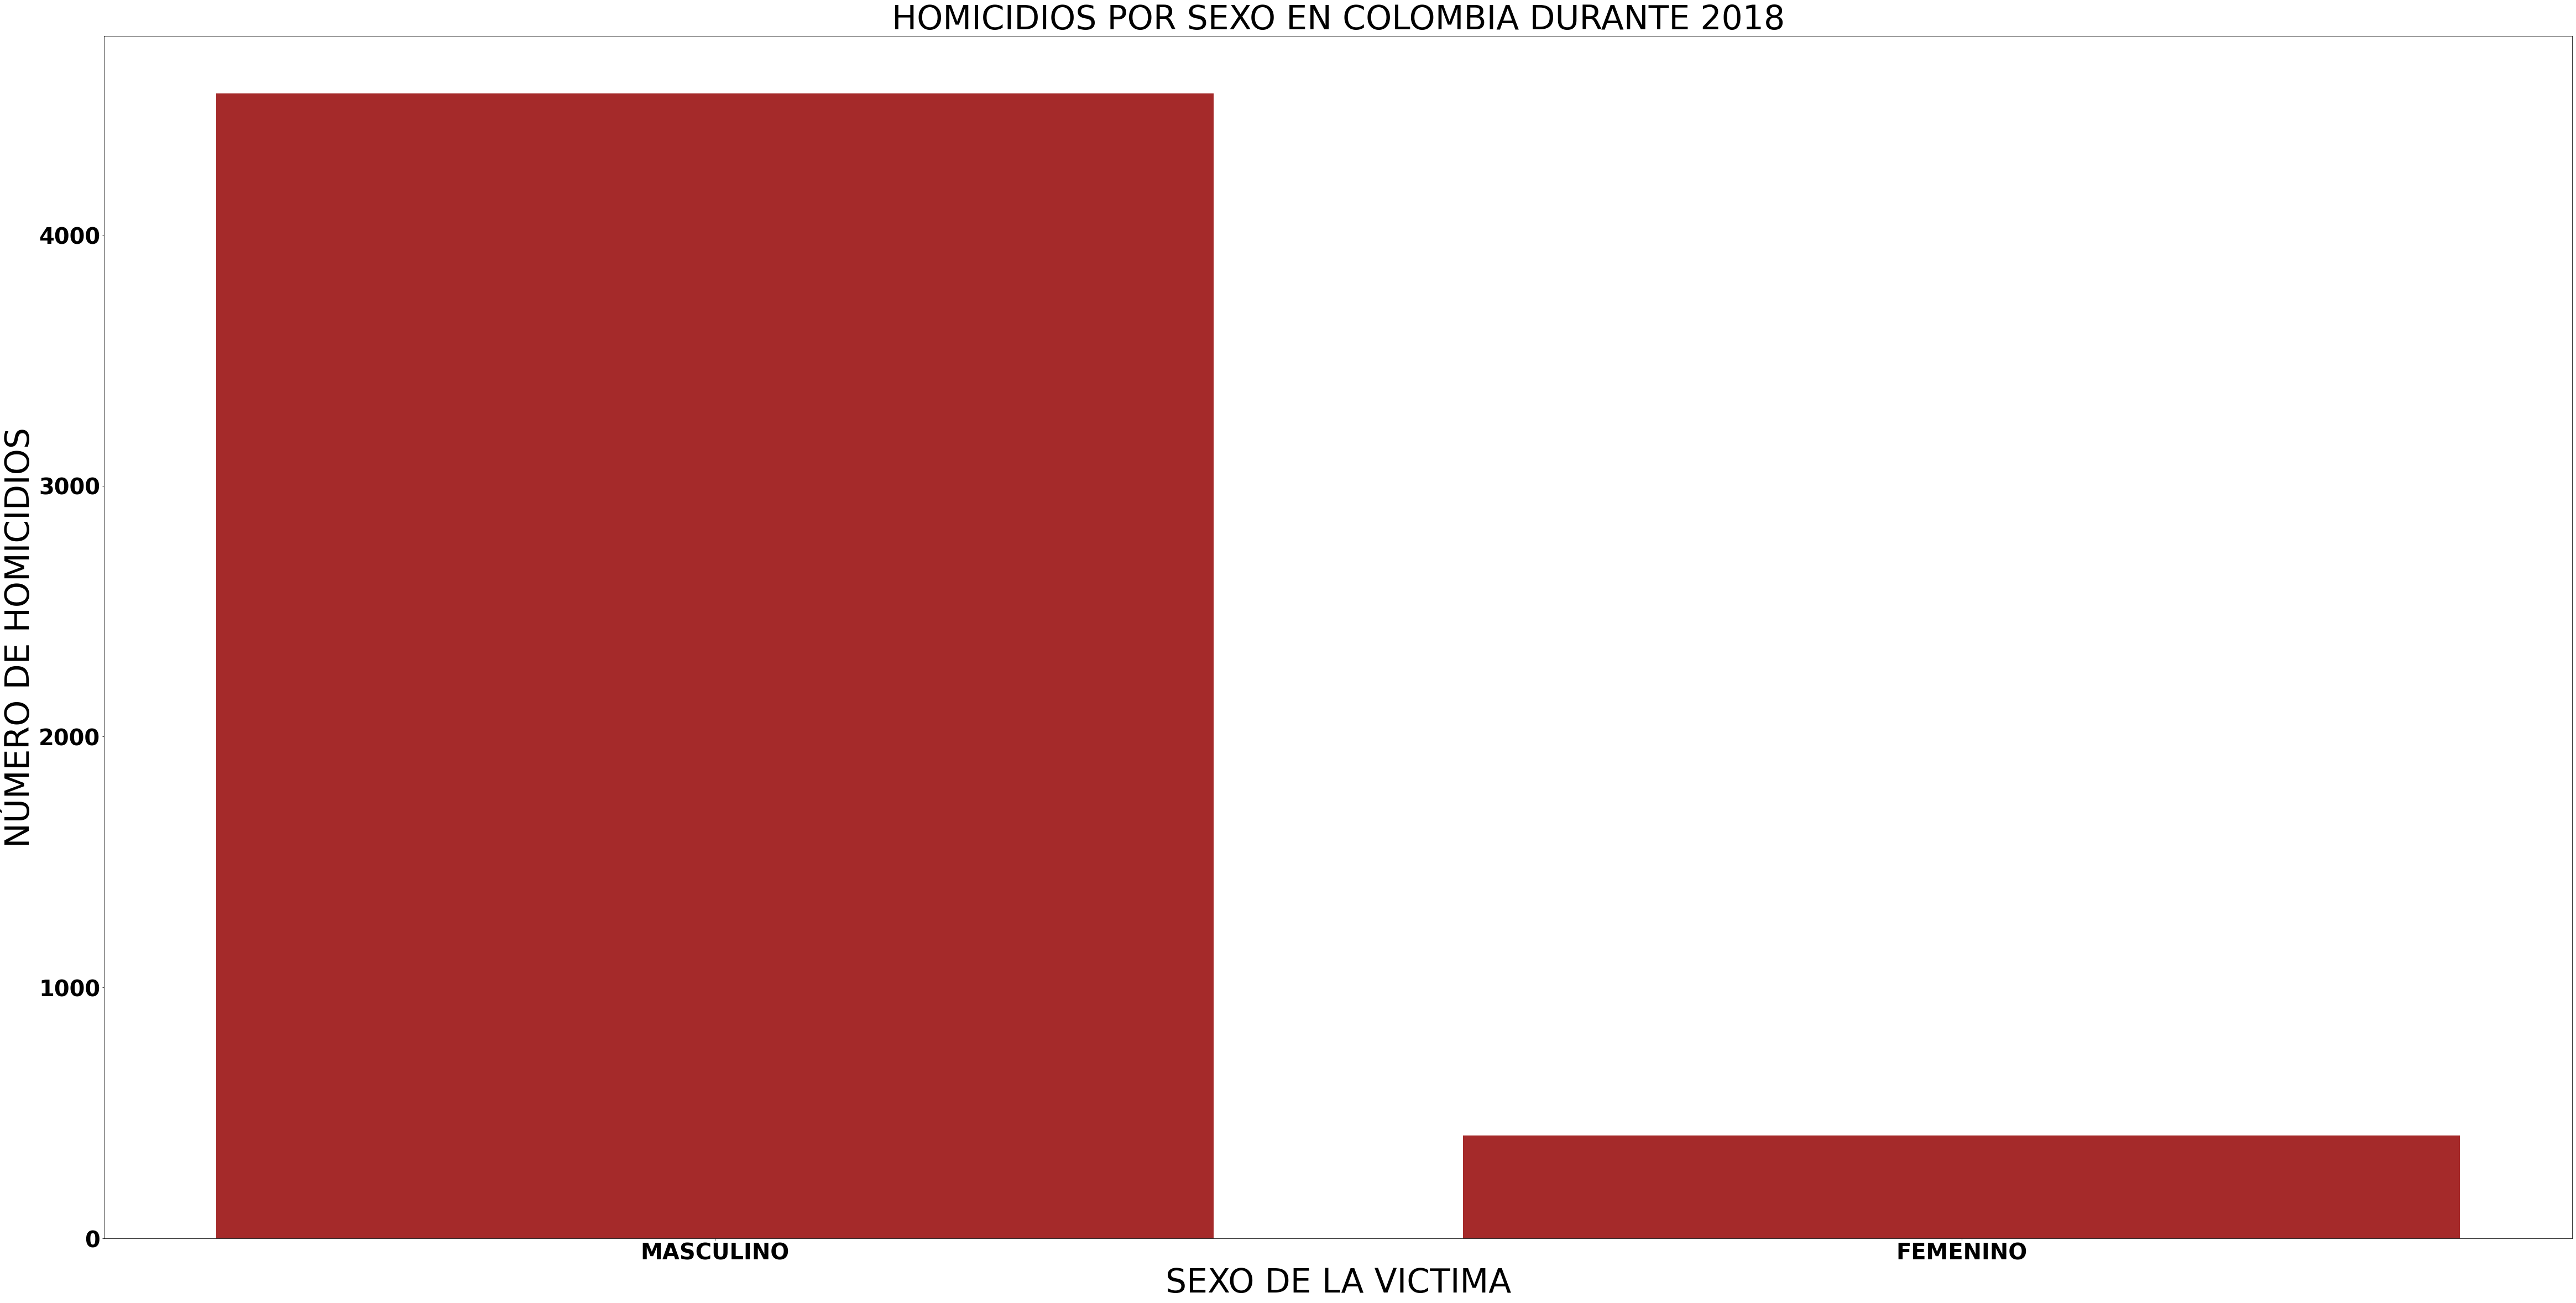

In [32]:
Historial_por_sexo=calcular_insights('Sexo', 0.1) #se calcula la lista de homicidios por sexo con un filtro de 0.1 medias para mostrar ambos sexos
print(Historial_por_sexo)
plt.bar(Historial_por_sexo.keys(), Historial_por_sexo.values(), color = 'brown')
plt.xlabel("SEXO DE LA VICTIMA", **axis_font)
plt.ylabel("NÚMERO DE HOMICIDIOS", **axis_font)
plt.title("HOMICIDIOS POR SEXO EN COLOMBIA DURANTE 2018", **axis_font)
plt.show()

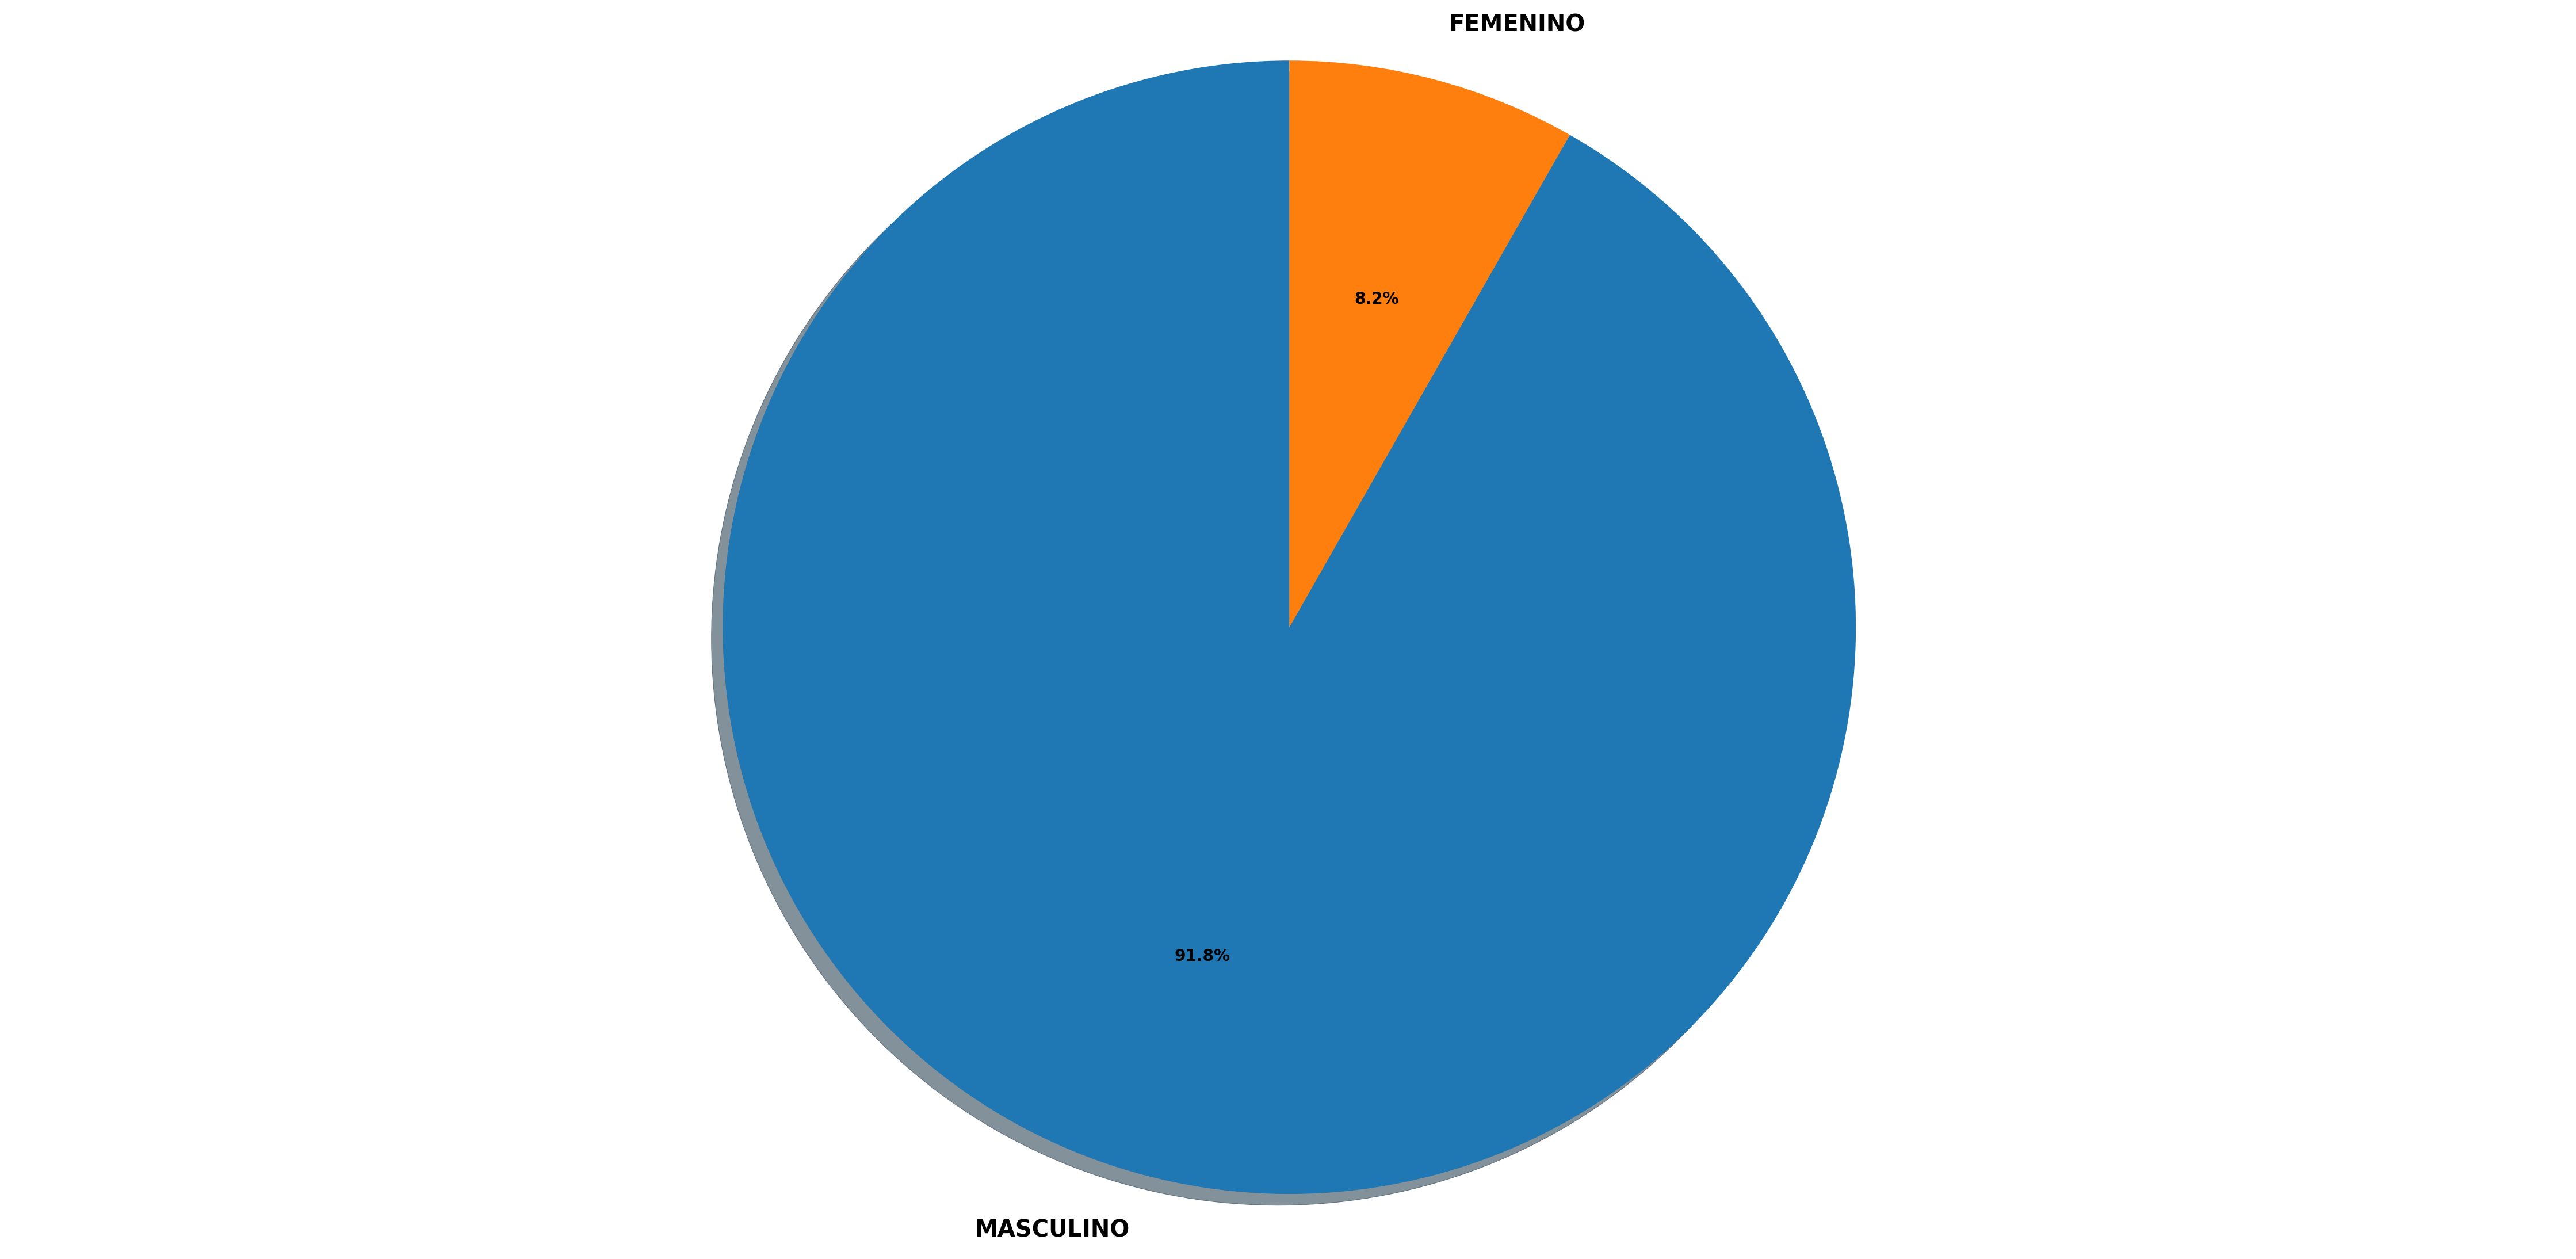

In [93]:
labels = Historial_por_sexo.keys() #los labels para una gráfica circular son las claves del diccionario.
sizes = Historial_por_sexo.values() #el tamaño son la cantidad de homicidios por cada sexo
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 28}

plt.rc('font', **font)
#se muestra la gráfica 
fig1, ax1 = plt.subplots() 
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Las gráficas evidencian que los homicidios son mayores en el sexo masculino que en el femenino, siendo la relación 11:1

###¿Qué estado civil predomina en las muertes?

A continuación se va a encontrar el número de homicidios en el año 2018 en función del estado civil usando la función "calcular_insights"

{'SOLTERO': 3150, 'UNION LIBRE': 1503, 'CASADO': 241}


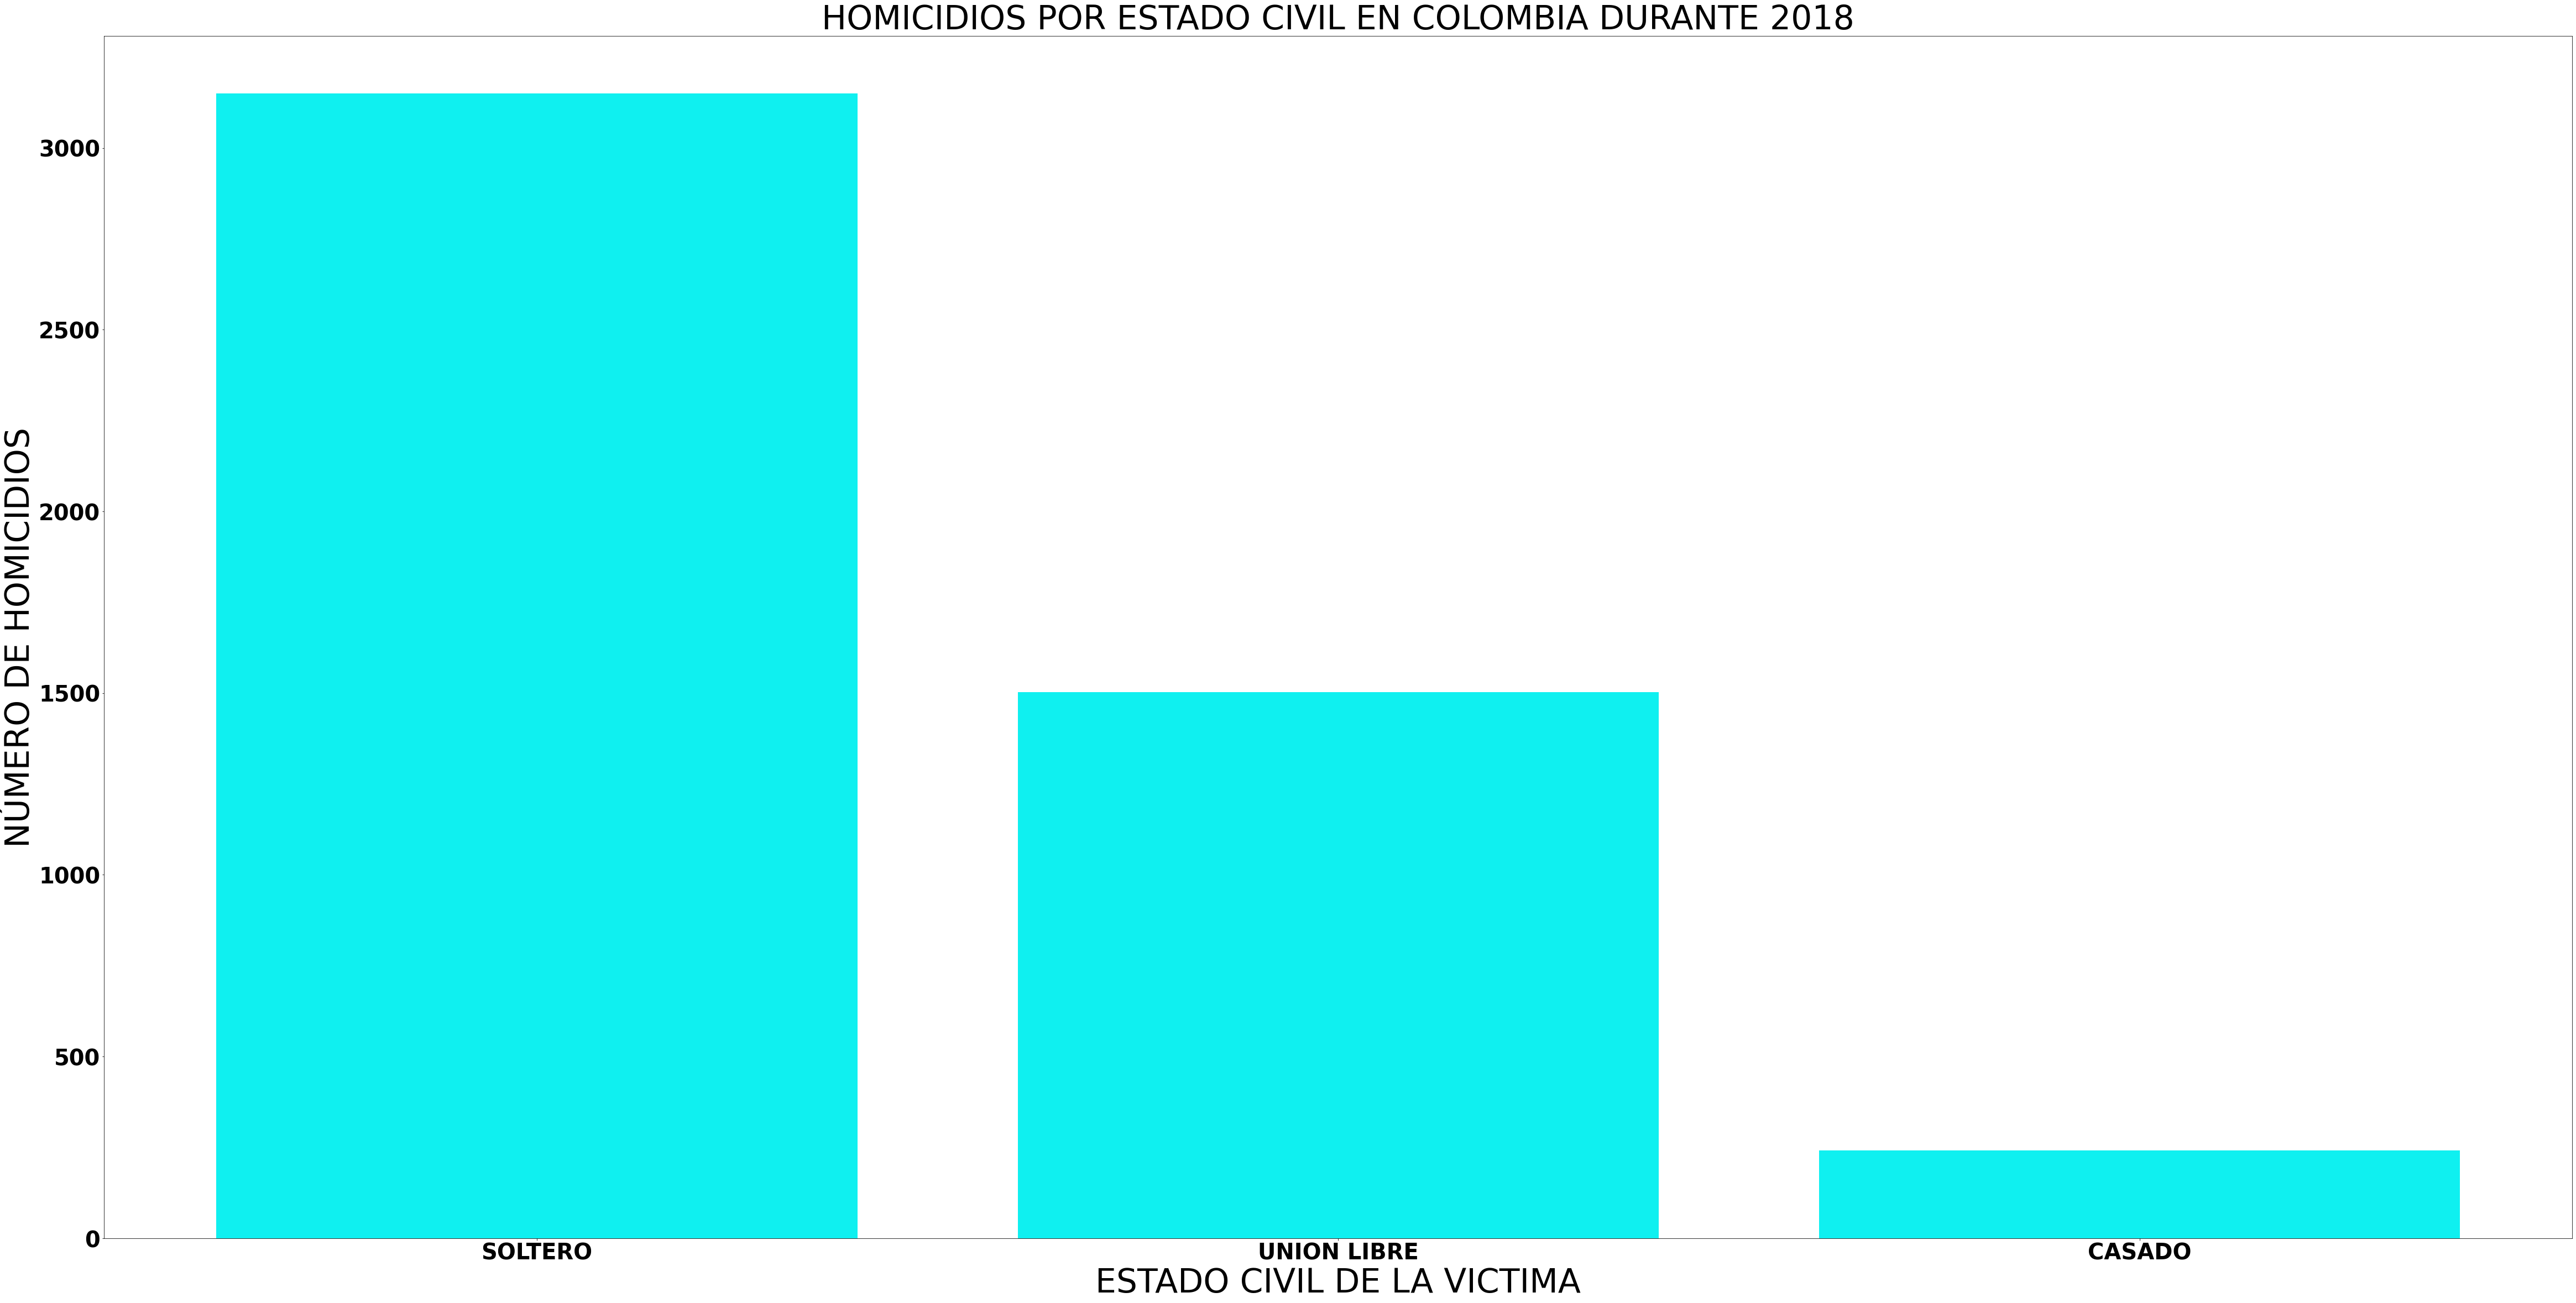

In [33]:
Historial_por_ec=calcular_insights('Estado civil', 0.1) #se calcula la lista de homicidios en función del estado civil con una media de 0.1
#para mostrar todos los estados civiles
print(Historial_por_ec)
plt.bar(Historial_por_ec.keys(), Historial_por_ec.values(), color = '#0ff0f0')
plt.xlabel("ESTADO CIVIL DE LA VICTIMA", **axis_font)
plt.ylabel("NÚMERO DE HOMICIDIOS", **axis_font)
plt.title("HOMICIDIOS POR ESTADO CIVIL EN COLOMBIA DURANTE 2018", **axis_font)
plt.show()

De la gráfica se puede concluir que los homicidios se concentran en la población soltera, siendo 3150 personas solteras las asesinadas en 2018, los menos violentados en este mismo año son las personas casadas con 241 personas muertas violentamente.

### ¿Cuáles son los Barrrios en cualquier municipio con mayor número de muertes en un rango de edad dado?

Para responder las preguntas restantes no es posible usar el mismo método usado hasta ahora y se deben plantear otros métodos, más parecidos al método usado para encontrar los barrios con más homicidios en cualquier hora y cualquier municipio del país.

In [34]:
#La función recibe como parámetros el municipio y el departamento que se desea consultar, y el rango de edad en el que se quiere conocer los homicidios
#y retorna una lista con los barrios con mayor número de homicidios
def Homicidios_municipio_edad(municipio, departamento, Edad_inicial, Edad_final,factor):
  Historial_por_edad = {} #diccionario para almacenar los valores de los homicidios y los barrios
  Datos_bogota = datos.loc[datos.loc[:, 'Municipio'] == municipio] # se filtran lo valores de la tabla por municipio
  Datos_bogota = Datos_bogota.loc[datos.loc[:, 'Departamento'] == departamento] #se filtran los valores por departamento para evitar errores
  a,b = Datos_bogota.shape # a = filas, b 0 columnas
  for i in range(a):
    edad = Datos_bogota.iloc[i,10] #se extrae la edad del registro actual
    if edad >= Edad_inicial and edad<=Edad_final: #si la edad está en el rango ingresado 
      Historial_por_edad[Datos_bogota.iloc[i,4]]=Historial_por_edad.get(Datos_bogota.iloc[i,4],0)+Datos_bogota.iloc[i,17] #se agrega el homicido al diccionario 

  HOMICIDIOS_NOTABLES_HORA = {}
  MEDIA_HOMICIDIOS2 = np.sum(list(Historial_por_edad.values()))/len(list(Historial_por_edad.keys())) #se calcula la media de homicidios
  for j,k in Historial_por_edad.items(): #se recorre el diccionario
    if k >= MEDIA_HOMICIDIOS2*factor: #si el valor supera el filtro
      HOMICIDIOS_NOTABLES_HORA[j] = k #se agrega el valor al nuevo diccionario
  return HOMICIDIOS_NOTABLES_HORA #se retorna el diccionario con los homicidios notables

{'CARACOLI E-19': 6, 'GRAN BRITALIA E-8': 5, 'LA FAVORITA E-14': 9, 'ARBORIZADORA ALTA E-19': 5, 'QUIBA E-19': 5}


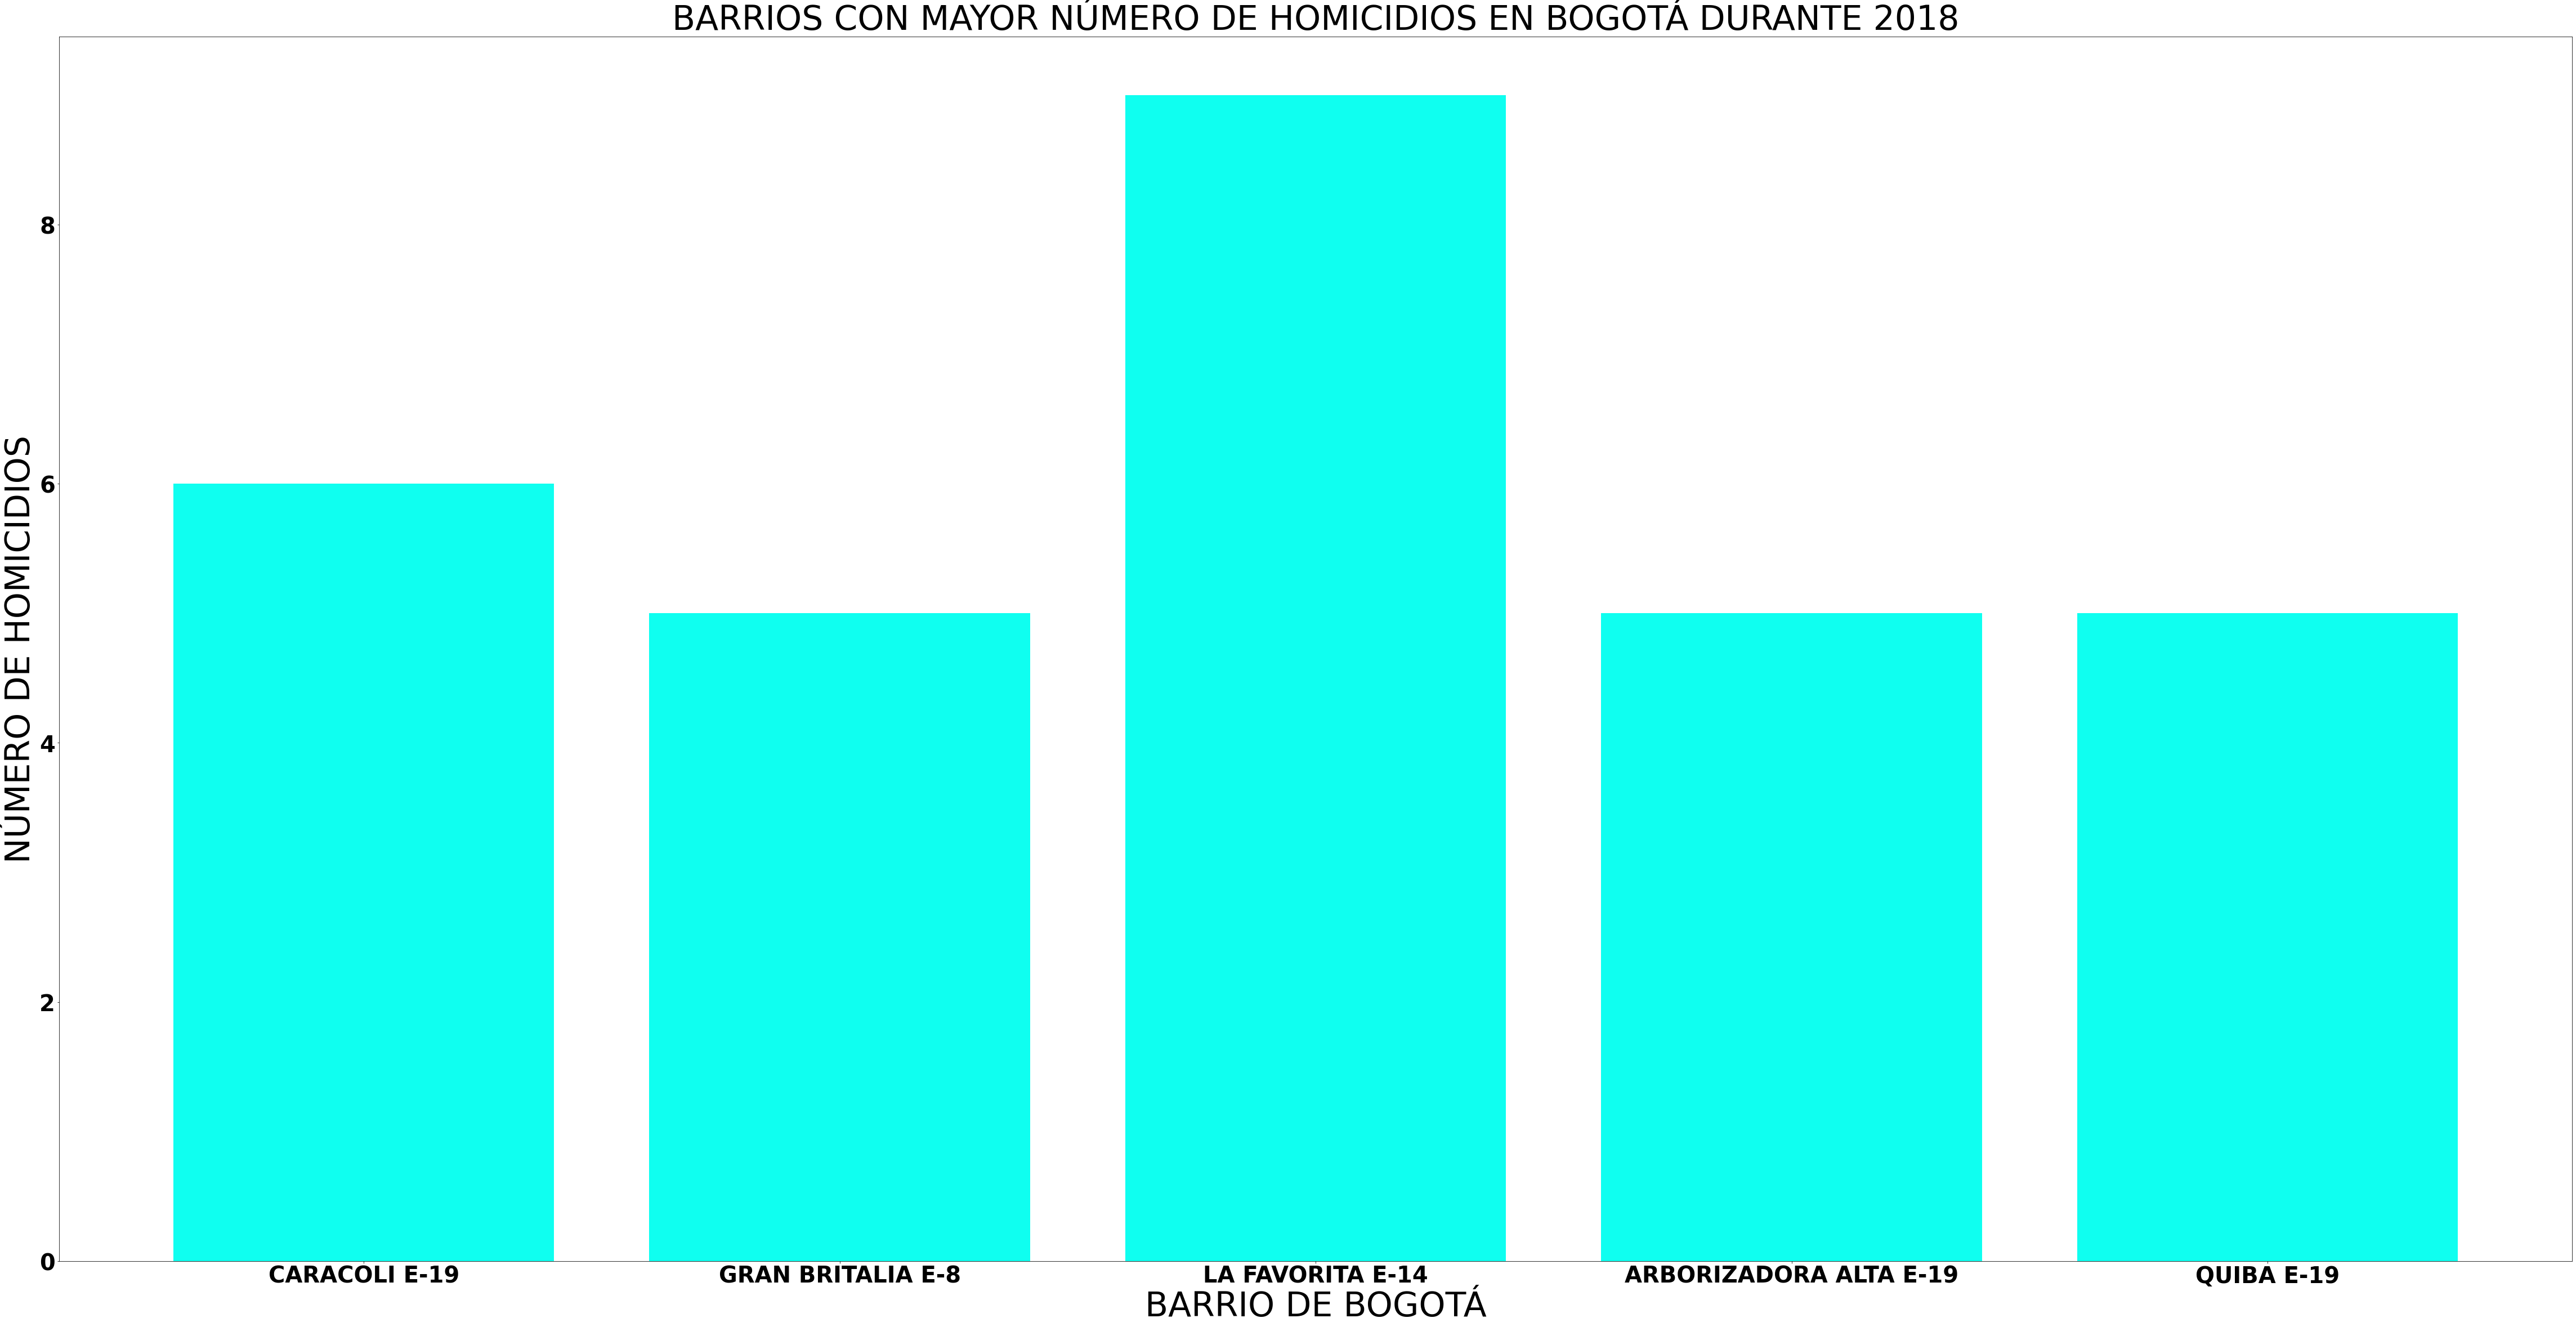

In [35]:
homicidios_bogota_edad = Homicidios_municipio_edad('BOGOTÁ D.C. (CT)','CUNDINAMARCA',20,60,3) #se buscan los barrios de bogotá con más homicidios entre los 20 y los 60 
print(homicidios_bogota_edad)
plt.bar(homicidios_bogota_edad.keys(), homicidios_bogota_edad.values(), color = '#0ffff0')
plt.xlabel("BARRIO DE BOGOTÁ", **axis_font)
plt.ylabel("NÚMERO DE HOMICIDIOS", **axis_font)
plt.title("BARRIOS CON MAYOR NÚMERO DE HOMICIDIOS EN BOGOTÁ DURANTE 2018", **axis_font)
plt.show()

Con esto puede concluirse que los barrios en Bogotá con más homicidios entre 20 y 60 años son La favorita con 9, Caracolí con 6, gran britalia, arborizadora y quiba, estos últimos con 5 casos.

### ¿Cuales son los Barrios en cualquier municipio de Colombia con más homicidios en 2018?

Un resultado interesante del método anterior es que puede extenderse a consultar lo barrios con más homicidios en cualquier rango de edad, por lo que se repetirá el proceso anterior para encontrar lo barrios en Bogotá con más homicidios en 2018

{'CARACOLI E-19': 6, 'GRAN BRITALIA E-8': 5, 'LA FAVORITA E-14': 9, 'ARBORIZADORA ALTA E-19': 5, 'LAS MARGARITAS E-8': 5, 'QUIBA E-19': 5}


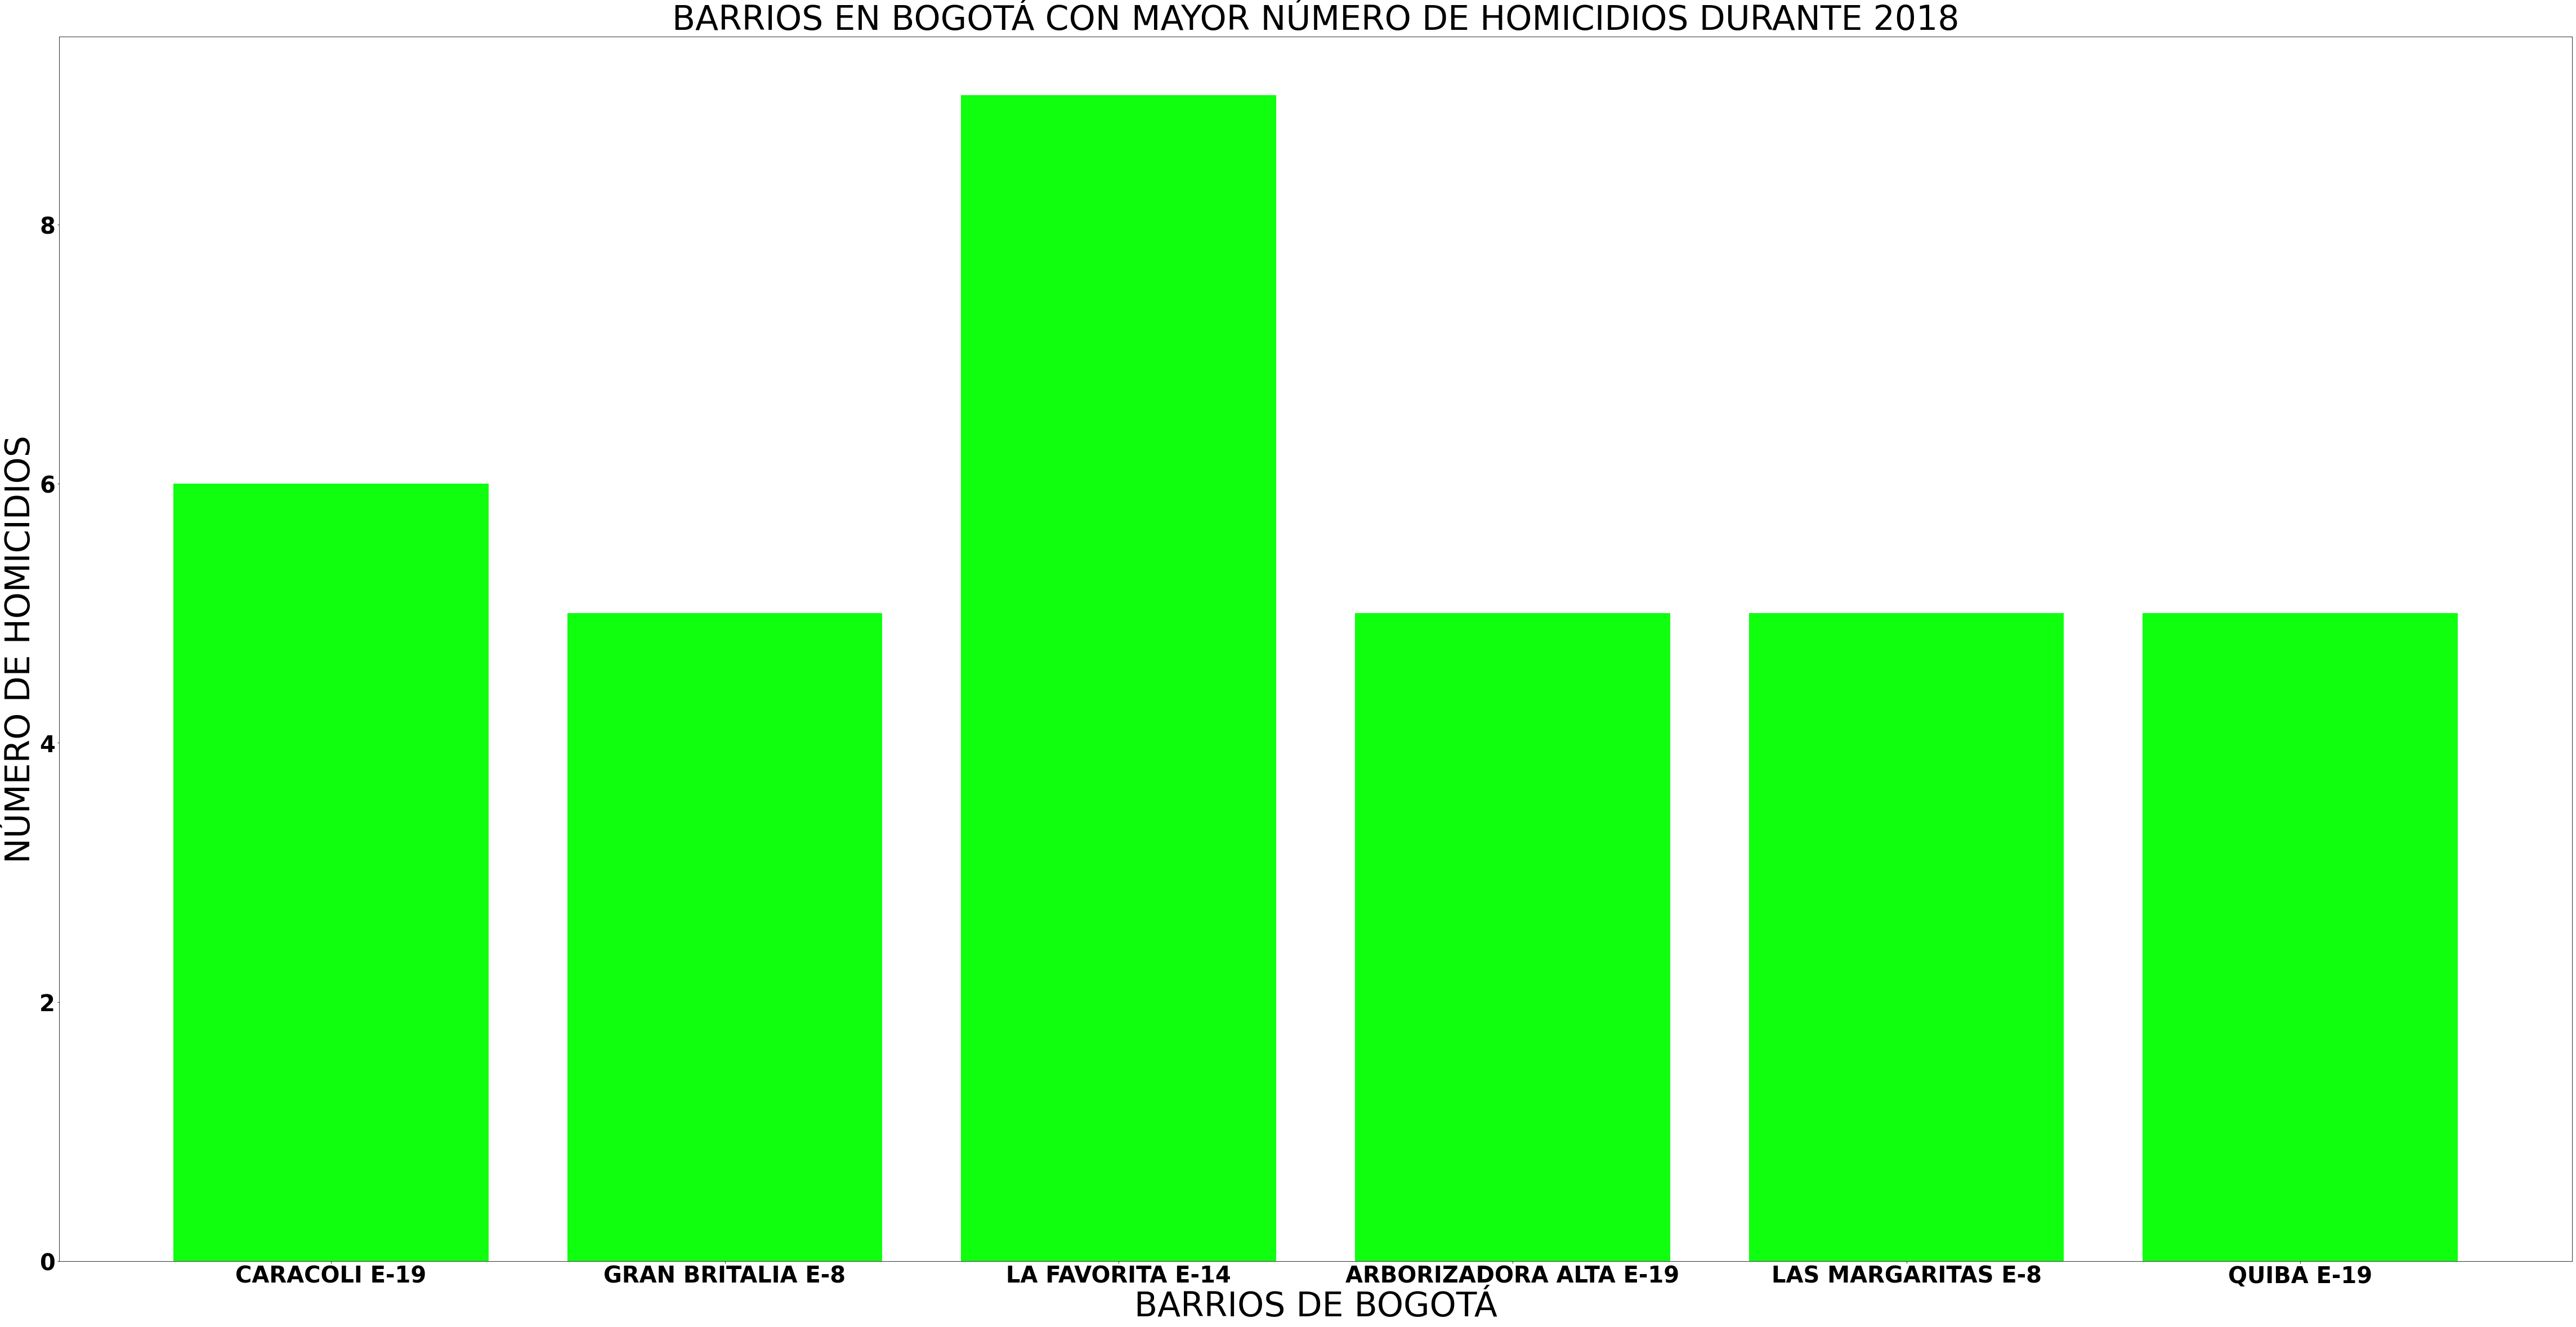

In [36]:
mas_homicidios_bogota = Homicidios_municipio_edad('BOGOTÁ D.C. (CT)','CUNDINAMARCA',0,100,3) #se buscan los barrios de bogotá con más homicidios 
print(mas_homicidios_bogota)
plt.bar(mas_homicidios_bogota.keys(), mas_homicidios_bogota.values(), color = '#0fff0f')
plt.xlabel("BARRIOS DE BOGOTÁ", **axis_font)
plt.ylabel("NÚMERO DE HOMICIDIOS", **axis_font)
plt.title("BARRIOS EN BOGOTÁ CON MAYOR NÚMERO DE HOMICIDIOS DURANTE 2018", **axis_font)
plt.show()

Con esto puede concluirse que los barrios en Bogotá con más homicidios entre 20 y 60 años son La favorita con 9, Caracolí con 6, gran britalia, arborizadora, las margaritas y quiba, estos últimos con 5 casos.

#Modelo de machine learning

¿Tendría sentido un modelo de machine learning para apoyar a la policia en su trabajo?

En este caso tiene mucho sentido crear un modelo de machine learning para encontrar factores que puedan ayudar a la policia a determinar cuanta fuerza policial necesita en determinados sectores. Esto se evidencia en los gráficos anteriores, donde se podía encontrar correlación entre cierto aspectos y los homicidios, como en el caso del sexo o el estado civil.

Además, se tiene una tabla con datos estructurados que pueden ser separados y codificados lo que hace que un modelo como una red neuronal o SVM pueda tener sentido, mas allá de que se pueda encontrar un accuracy adecuado.

Por último se puede decir que, aunque los homicidios dependen de la mayoría de factores listados, muchos de estos son muy especifios y/o individuales y no permiten crear modelos de análisis, por lo que deben también ser descartados en los análisis.

¿Qué tipo de modelo escogería?

Para este problema es posible crear 2 tipos de modelos, tanto de clasificación como de regresión. En este sentido, el modelo de clasificación, usaría factores como el mes, departamento, municipio, día de la semana y clase de sitio, y los clasificaría en diferentes clases de peligrosidad usando el número de asesinatos para crear las clases. El problema con esta forma de trabajar es, además de la poca cantidad de datos que se tiene para cada clase, el desbalance general del problema, con condiciones que tienen muchos más datos que otras clases, el modelo terminaría por solo predecir algunas de las clases de bajo peligro y dejaría de lado las demás clases. Sin embargo, es posible tratar este problema también como un problema no balanceado y asignar pesos a las clases con menos datos. Esta aproximación puede presentar ambiguedad por lo que no se construirá este modelo.

La mejor aproximación para este problema es una de regresión lineal con una red neuronal o un svm, donde el tamaño de la entrada va a estar Codificada en One hot encoding y serán 613 municipios, 7 días de la semana y 111 clases de sitio (también codificadas en one hot encoding). Como salida se tendrán el número de homicidios para esas condiciones especificas.

A continuación se construye el dataset final para este proposito:

In [70]:
Historial_por_sitio=calcular_insights('Clase de sitio', 0.03) #se recrea la lista con todas las clases de sitio
X1 = pd.DataFrame({'numbers': []}) #dataframe para almacenar la lista de días de la semana
X2 = pd.DataFrame({'numbers2': []}) #dataframe para almacenar la lista de municipios
X3 = pd.DataFrame({'numbers3': []}) #dataframe para almacenar la lista de clases de sitio
cantidad_homocidios_codigo = {} #array para almacenar la cantidad de homicidios dadas unas condiciones
count = 0 #contados de almacenamieto
for i in range(datos.shape[0]): #se recorren los datos
    #se construye un codigo unico para la condición dada
    codigo = datos.loc[i,'Municipio']+", "+datos.loc[i,'Departamento']+";"+datos.loc[i,'Día']+";"+datos.loc[i,'Clase de sitio']
    if cantidad_homocidios_codigo.get(codigo,0) == 0: #si es la primera vez que esta condición se presenta
      X2.loc[count]=[datos.loc[i,'Municipio']+", "+datos.loc[i,'Departamento']] #se almacena el municipio
      X1.loc[count]=[datos.loc[i,'Día']] #se almacena el dia
      X3.loc[count]=[datos.loc[i,'Clase de sitio']] #se almacena la clase de sitio
      count += 1
    #se cuenta la cantidad de homicidios para esas condiciones
    cantidad_homocidios_codigo[codigo] = cantidad_homocidios_codigo.get(codigo,0)+datos.loc[i,'Cantidad']
    

In [71]:
from sklearn.preprocessing import OneHotEncoder
X_DEP = OneHotEncoder().fit_transform(X2).toarray() #se realiza el OneHotEncoding de los departamentos
X_DIA = OneHotEncoder().fit_transform(X1).toarray() ##se realiza el OneHotEncoding de los dias
X_CLASE = OneHotEncoder().fit_transform(X3).toarray() #se realiza el OneHotEncoding de las clases de sitio

X = np.hstack((X_DEP,X_DIA,X_CLASE)) #se unifican los arrays para crear una solo base de datos

y = np.zeros((2596,1)) #array para almacenar las etiquetas de salida

y1 = list(cantidad_homocidios_codigo.values()) #array que contiene las etiquetas de salida

for i in range(y.shape[0]): #con el fin de eliminar problemas de dimensionalidad de asignan los valores
#al array
  y[i] = y1[i]

temporal = np.hstack((X, y)) #se unifican los valores de X y de Y

import random
random.shuffle(temporal) #con el fin de tener una repartición uniforma de los datos, estos se mezclan
#se toma el 80% de los datos para el set de entrenamiento
#se toma 10% para el set de validación
#se toma 10% para el set de test
y_train = temporal[:,731][0:2076] #se seleccionan los datos de entrenamiento
y_val = temporal[:,731][2076:2336] #se seleccionan los datos de validación
y_test = temporal[:,731][2336:2596] #se seleccionan los datos de test
X = temporal[:,0:731] #nuevo array de características
X_train = X[0:2076] #se seleccionan los datos de entrenamiento
X_val = X[2076:2336] #se seleccionan los datos de validación
X_test = X[2336:2596] #se seleccionan los datos de test

La primera aproximación a la solución del problema es usar el modelo de regresion lineal simple de sklearn, el cual permite crear un modelo simple, entrenalo y medir el error encontrado 

In [79]:
from sklearn import linear_model #se importa el modelo lineal 
from sklearn.metrics import mean_squared_error as error_cuadrado #se importa la herramienta de medición de error

regr = linear_model.LinearRegression() #Se crea el modelo de regresión lineal
 
modelo = regr.fit(X_train,y_train) #se entrena el modelo en el set de entrenamiento
y_pred = modelo.predict(X_val) #se predicen los valores para el set de validación
error = error_cuadrado(y_pred, y_val) #se calcula el error del modelo en este set
print("el error del modelo en los datos de validacion es: "+str(error))
y_pred2 = modelo.predict(X_test) #se predicen los valores para el set de test
error2 = error_cuadrado(y_pred2, y_test) #se calcula el error del modelo en este set
print("el error del modelo en los datos de test es: "+str(error2))


el error del modelo en los datos de validacion es: 1.5148010039057416e+27
el error del modelo en los datos de test es: 3.90285738869482e+27


Se puede observar que se obtuvo un muy mal performance para este caso, esto puede deberse tanto a la poca cantidad de datos, como a la simplicidad del modelo. En caso de que el problema sea el primero, no es posible solucionarlo. Sin embargo es posible tratar de solucionar el segundo problema usando keras para crear un modelo más complejo como una red neuronal.

In [89]:
from keras.models import Sequential #se importa la herramienta para crear modelos secuenciale de keras
from keras.layers.core import Dense #se importa la herramienta para crear capas en redes neuronales
from sklearn.metrics import mean_squared_error as error_cuadrado #heramienta de medición de error

model = Sequential() #se crea el modelo
model.add(Dense(731, input_dim=731, activation='relu')) #primera y segunda capa del modelo, con entrada de 731 características
#y 731 neuronas ocultas 
model.add(Dense(400, activation='relu')) #la capa 3 tiene 400 neuronas y activación relu
model.add(Dense(200, activation='relu')) #la capa 4 tiene 200 neuronas y activación relu
model.add(Dense(1, activation='linear')) #la capa de salida tiene 1 neurona con activación lineal
#para transformar la red en un regresor lineal 
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['mean_squared_error']) #se compila el modelo usando la perdida y la metrica error cuadratico medio,
 
model.fit(X_train, y_train, epochs=10) #se entrena el modelo durante 10 épocas

Epoch 1/10
65/65 [==============================] - 1s 8ms/step - loss: 54.0316 - mean_squared_error: 54.0316
Epoch 2/10
65/65 [==============================] - 1s 8ms/step - loss: 8.7016 - mean_squared_error: 8.7016
Epoch 3/10
65/65 [==============================] - 1s 8ms/step - loss: 4.1265 - mean_squared_error: 4.1265
Epoch 4/10
65/65 [==============================] - 1s 8ms/step - loss: 1.5322 - mean_squared_error: 1.5322
Epoch 5/10
65/65 [==============================] - 1s 8ms/step - loss: 0.7967 - mean_squared_error: 0.7967
Epoch 6/10
65/65 [==============================] - 1s 8ms/step - loss: 0.6101 - mean_squared_error: 0.6101
Epoch 7/10
65/65 [==============================] - 1s 8ms/step - loss: 0.3282 - mean_squared_error: 0.3282
Epoch 8/10
65/65 [==============================] - 1s 8ms/step - loss: 0.2133 - mean_squared_error: 0.2133
Epoch 9/10
65/65 [==============================] - 1s 9ms/step - loss: 0.1767 - mean_squared_error: 0.1767
Epoch 10/10
65/65 [=======

In [90]:
y_pred1 = model.predict(X_val) #se predice el valor en los datos de validación

error1 = error_cuadrado(y_pred1, y_val) #se calcula el error cuadrático
print("El error medio en datos de validación es: "+str(np.sqrt(error1))+" Homicidios")

y_pred = model.predict(X_test) #se predice el valor en los datos de test
 
error = error_cuadrado(y_pred, y_test) #se calcula el error cuadrático
print("El error medio en datos de Test es: "+str(np.sqrt(error))+" Homicidios")

El error medio en datos de validación es: 1.30081827934318 Homicidios
El error medio en datos de Test es: 1.8634069741598676 Homicidios


Después de probar distintos modelos con distinto número de capas, disintos optimizadores, número de neuronas y funciones de perdidas, Como se puede observar el modelo presenta un muy buen performance, con error absoluto pequeño, en los datos de validación y entrenamiento.



---

Por último, se crea una interfaz que permite usar el modelo y predecir condiciones unitarias teniendo el nombre de la ciudad y el departamento, día de la semana y la clase de sitio. Esto puede ser concebido como un inicio a una API para la puesta en producción.

In [68]:
print('Aplicación que permite usar el modelo de Predicción de homicidios en las ciudades de Colombia')
ciudad = input('Ingrese Aquí la ciudad: ')
departamento = input('ingrese Aquí su departamento: ')
dia = input('ingrese aquí el día que desea consultar: ')
sitio = input('ingrese aquí la clase de sitio: ')

string = ciudad+", "+departamento
count = 0
for i in range(X2['numbers2'].shape[0]):
  if X2.loc[i,'numbers2'] == string:
    codigo1 = X_DEP[i:i+1]
for i in range(X1['numbers'].shape[0]):
  if X1.loc[i,'numbers'] == dia:
    codigo2 = X_DIA[i:i+1]
for i in range(X3['numbers3'].shape[0]):
  if X3.loc[i,'numbers3'] == sitio:
    codigo3 = X_CLASE[i:i+1]

codigo = np.hstack((codigo1,codigo2,codigo3,))
prediccion = model.predict(codigo)

print("En estas condiciones se espera un numero máximo de: "+  str(prediccion) + " homicidios")

Aplicación que permite usar el modelo de Predicción de homicidios en las ciudades de Colombia
Ingrese Aquí la ciudad: BOGOTÁ D.C. (CT)
ingrese Aquí su departamento: CUNDINAMARCA
ingrese aquí el día que desea consultar: Lunes
ingrese aquí la clase de sitio: VIAS PUBLICAS
En estas condiciones se espera un numero máximo de: [[1.]] homicidios con las condiciones antes mencionadas


#Cómo desplegaría su modelo? Proponga una arquitectura y expliquela

Para poder desplegar el modelo y sacarlo a producción lo primero que se debe hacer es Hospedar el modelo en un servidor que permita correr dicho modelo de forma remota con recursos de hadware avanzados que el usuario final puede no tener y con un almacenamiento que permita su rapido acceso. Para esto es posible usar Google Cloud ML engine, Herramienta PaaS, la cual permite tanto entrenar modelos con GPUS y TPUS avanzadas, como predecir valores futuros con los mismos recursos de Hadware. En este sentido, La posibilidad de re-entrar modelos es útil para que nuestro modelo evolucione en el tiempo con datasets más complejos. Por último es necesario decir que en esta app de google es posible serializar un modelo y guardarlo de forma que se optimice el espacio de almacenamiento y el tiempo de acceso.


---



Si el modelo recopila información de los usuarios, es necesario que este tenga acceso directo a una base de datos, como termino general para la mayoria de casos es mejor usar una base de datos sql, ya que estas son más escalables para grandes cantidades de datos y permiten realizar consultas de forma rapida. Además, google permite realizar preprocesamiento de datos de entrada de forma sencilla por lo que en este punto también es posible usar las herramientas de google para este proposito.


---


El último paso para desplegar un modelo correctamente es crear una API que permita a muchos usuarios sin conocimiento en machine learning usar nuestro modelo. Generalmente se usan las APIS flask y Docker para realizar este proceso, ya que estas presentan muchas ventajas en el almacenamiento y recopilación de datos del modelo. Sin embargo, Dado que se quiere almacenar la app en los servicios de google, también es posible usar estos mismos servicios para la creación de la API ya que estos están optimizados para el flujo de datos y permiten usar herramientas actualizadas para diferentes tipos de interacciones.

---



Una desventaja de esta forma de desplegar nuestros modelos es el costo que involucra, ya que para aplicaciones con mucho flujo de datos, las herramientas PaaS de google costarían mucho dinero para una startup que esté iniciando en el mundo del análisis de datos.


---


En conclusión, con el fin de implementar un modelo de machine learning y ponerlo en producción, se propone una arquitectura "triangulo" basada en google ML engine, donde se tiene el modelo almacenado y serializado, conectado a su vez a un motor de bases de datos para tratar con el flujo de datos que van a provenir de un modulo de preprocesamiento de información conectado a una API que será creada en estos mismos servicios y que estará conectada también al modelo.



##Arquitectura de los modelos

Respecto a la arquitectura que debe llevar el modelo en si mismo, esta debe ser pensada teniendo en cuenta los objetivos de esta. Por ejemplo, si es necesario que esta procese video en tiempo real de muchos usuarios a la vez, es necesario pensar en una arquitectura convolucional optimizada para frames de video que pueda responder en pocos segundos a soliitud de la API.


---


del mismo modo, se puede querer que el modelo se actualice constantemente, por lo que debe tener una comunicación rapida con la base de datos y debe ser facil de entrenar para no tener que suspender el funcionamiento del sistema por mucho tiempo. 


---


Del mismo modo, se espera que el modelo pueda escalar y evolucionar al contar con más datos por lo que la arquitectura debe contar con la opción de aumentar características, número de parámetros y/o capas.



---

En conclusión respecto a la arquitectura del modelo, es necesario contar con unas u otras carácterísticas, que pueden costar bastante dinero a una empresa para ser implementadas con tal de que coincidan con las exigencias del modelo puesto en producción y donde se necesiten hacer pocos ajustes drasticos en el futuro. 



#Sergio Daniel Diaz Ortiz, Aspirante al cargo de data engineer.